# Experiments

In [1]:
# Import.
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from models.principal_rbm_alpha import RBM
from models.principal_dbn_alpha import DBN
from models.principal_dnn_mnist import DNN
from utils import (
    load_mnist,
    load_alphadigit,
    read_alpha_digit,
    plot_characters_alphadigit,
    plot_original_and_generated_images
)

In [2]:
DATA_FOLDER = "../data/"
ALPHA_DIGIT_PATH = os.path.join(DATA_FOLDER, "binaryalphadigs.mat")
MNIST_PATH = os.path.join(DATA_FOLDER, "mnist_all.mat")

for path in [ALPHA_DIGIT_PATH, MNIST_PATH]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file {path} does not exist.")

SEED = 42

## 1. Study on BinaryAlphaDigit

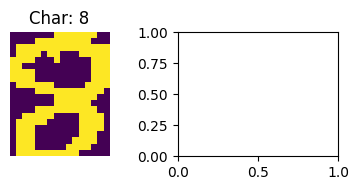

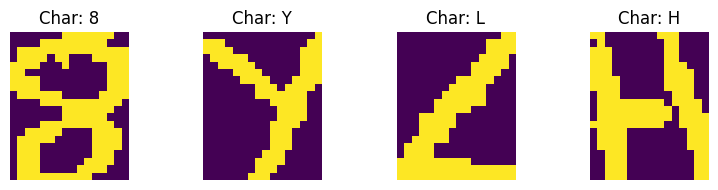

Original data: (36, 39)
Original data (unstack samples -> flatten images): (1365, 320)
Subset (1 character) data  (39, 320)
Subset (4 characters) data  (156, 320)


In [3]:
alphadigit = load_alphadigit(ALPHA_DIGIT_PATH)

chars_1 = [8]
chars_2 = chars_1 + ["Y"]
chars_3 = chars_2 + ["L"]
chars_4 = chars_3 + ["H"]
data_alpha_1 = read_alpha_digit(chars_1, data=alphadigit, use_data=True)
data_alpha_2 = read_alpha_digit(chars_2, data=alphadigit, use_data=True)
data_alpha_3 = read_alpha_digit(chars_3, data=alphadigit, use_data=True)
data_alpha_4 = read_alpha_digit(chars_4, data=alphadigit, use_data=True)

all_chars = np.arange(0, 35).tolist()
alphadigit_data = read_alpha_digit(all_chars, data=alphadigit, use_data=True) # read all characters

plot_characters_alphadigit(chars_1, data_alpha_1)
plot_characters_alphadigit(chars_4, data_alpha_4)

print("Original data:", alphadigit.shape)
print("Original data (unstack samples -> flatten images):", alphadigit_data.shape)
print(f"Subset ({len(chars_1)} character) data ", data_alpha_1.shape)
print(f"Subset ({len(chars_4)} characters) data ", data_alpha_4.shape)

### RBM

In [4]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

# Initialize RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=SEED)
print(rbm)

# Train RBM
rbm.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

RBM(n_visible=320, n_hidden=200)


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 384.64it/s]


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 416.60it/s]


RBM(n_visible=320, n_hidden=200)

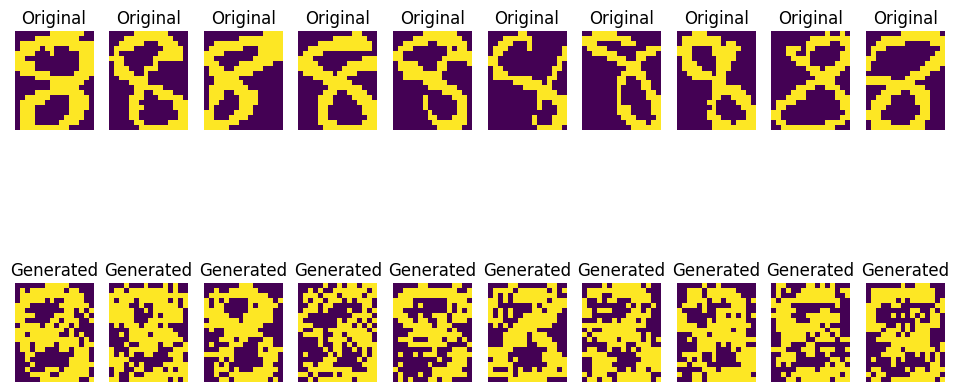

In [5]:
# Generate samples
generated_samples = rbm.generate_image(n_samples=10, n_gibbs_steps=1)

plot_original_and_generated_images(data_alpha, generated_samples, **{"cmap":None})

### DBN

In [6]:
data_alpha = data_alpha_1
n_chars = data_alpha.shape[0] / 39

# Parameters
n_visible = data_alpha.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)
hidden_layer_sizes = [200, 200, 200]

learning_rate = 0.1
n_epochs = 100
batch_size = int(8 * n_chars)

dbn = DBN(n_visible=n_visible, hidden_layer_sizes=hidden_layer_sizes, random_state=SEED)
dbn.train(data_alpha, learning_rate=learning_rate, n_epochs=n_epochs, batch_size=batch_size)

Training RBM layers: 100%|██████████| 3/3 [00:04<00:00,  1.42s/layer]


DBN([
 RBM(n_visible=320, n_hidden=200),
 RBM(n_visible=200, n_hidden=200),
 RBM(n_visible=200, n_hidden=200)
])

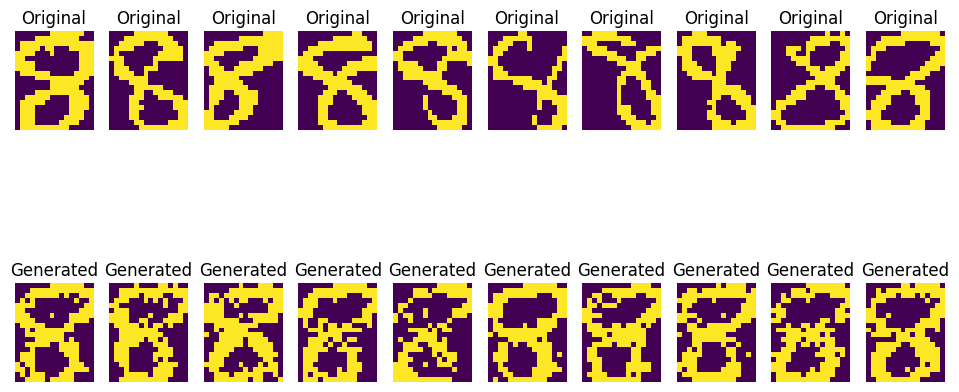

In [7]:
# # Generate images
generated_images = dbn.generate_image(n_samples=10, n_gibbs_steps=1)

# Display generated images
plot_original_and_generated_images(data_alpha, generated_images, **{"cmap":None})

### MNIST

In [8]:
import scipy.io

In [9]:
def load_mnist(mnist_path, mnist_dict=None, use_dict=False):
    if not use_dict:
        mnist_dict = scipy.io.loadmat(mnist_path)
    
    X_train = np.concatenate([mnist_dict[f"train{i}"] for i in range(10)], axis=0)
    X_test = np.concatenate([mnist_dict[f"test{i}"] for i in range(10)], axis=0)
    
    y_train = np.concatenate([np.eye(10)[[i]*mnist_dict[f"train{i}"].shape[0]] for i in range(10)], axis=0)
    y_test = np.concatenate([np.eye(10)[[i]*mnist_dict[f"test{i}"].shape[0]] for i in range(10)], axis=0)

    return X_train, y_train, X_test, y_test


def sample_indices(data_size: int, sample_size: int, random_state=None) -> np.ndarray:
    """
    Randomly sample indices from the range [0, data_size) without replacement.

    Parameters:
        data_size (int): Total number of indices available.
        sample_size (int): Number of indices to sample.
        random_state: Random seed for reproducibility.

    Returns:
        numpy.ndarray: Array of sampled indices.
    """
    rng = np.random.default_rng(random_state)
    if sample_size >= data_size:
        return np.arange(data_size)

    sampled_indices = rng.choice(data_size, size=sample_size, replace=False)
    return sampled_indices

def sample_mnist(X_train: np.ndarray, y_train: np.ndarray, sample_size: int, random_state=None) -> tuple:
    """
    Randomly sample a subset of samples from the MNIST dataset.

    Parameters:
        X_train (numpy.ndarray): Training data.
        y_train (numpy.ndarray): Training labels.
        sample_size (int): Number of samples to sample.
        random_state: Random seed for reproducibility.

    Returns:
        tuple: Sampled subset of training data and labels.
    """
    # Sample indices
    indices = sample_indices(len(X_train), sample_size, random_state=random_state)
    
    # Sample data and labels
    sampled_X_train = X_train[indices]
    sampled_y_train = y_train[indices]
    
    return sampled_X_train, sampled_y_train


def binarize_images(images):
    threshold = 127
    binary_images = np.where(images > threshold, 1, 0)
    return binary_images

mnist_train, mnist_train_labels, mnist_test, mnist_test_labels = (
    load_mnist(MNIST_PATH)
)


# Binarize the images
binary_mnist_train = binarize_images(mnist_train)
binary_mnist_test = binarize_images(mnist_test)


[mnist.shape for mnist in (mnist_train, mnist_train_labels, mnist_test, mnist_test_labels)]

[(60000, 784), (60000, 10), (10000, 784), (10000, 10)]

In [10]:
mnist_train_30000, mnist_train_labels_30000 = sample_mnist(mnist_train, mnist_train_labels, 30_000, 42)
mnist_train_30000.shape, mnist_train_labels_30000.shape

((30000, 784), (30000, 10))

In [11]:
print(mnist_train.max(), binary_mnist_train.max())

255 1


MNIST (60000, 28, 28)


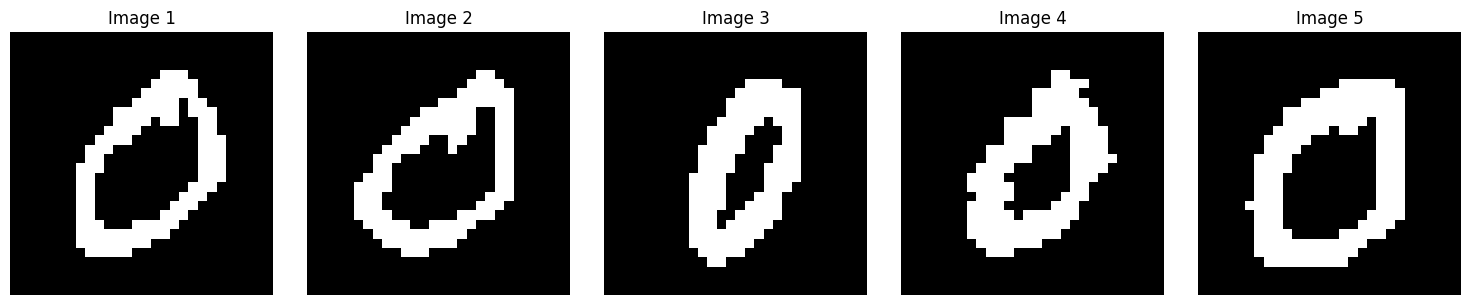

In [12]:
# Reshape mnist_train to its original shape
image_height = 28
image_width = 28
num_samples = binary_mnist_train.shape[0]
binary_mnist_train_images = binary_mnist_train.reshape(num_samples, image_height, image_width)
print("MNIST", binary_mnist_train_images.shape)

# Plot some images from mnist_train
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))
for i in range(num_images_to_plot):
    axes[i].imshow(binary_mnist_train_images[i], cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
help(DNN)

Help on class DNN in module models.principal_dnn_mnist:

class DNN(models.principal_dbn_alpha.DBN)
 |  DNN(input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |  
 |  Method resolution order:
 |      DNN
 |      models.principal_dbn_alpha.DBN
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, key)
 |  
 |  __init__(self, input_dim: int, output_dim: int, hidden_layer_sizes: List[int], random_state=None)
 |      Initialize the Deep Neural Network (DNN).
 |      
 |      Parameters:
 |      - input_dim (int): Dimension of the input.
 |      - output_dim (int): Dimension of the output.
 |      - hidden_layer_sizes (List[int]): List of sizes for each hidden layer.
 |      - random_state: Random seed for reproducibility.
 |  
 |  __len__(self)
 |  
 |  __repr__(self)
 |      Return a string representation of the DBN object.
 |  
 |  backpropagation(self, input_data: numpy.ndarray, labels: numpy.ndarray, n_epochs: int = 100, learn

In [14]:
from copy import copy, deepcopy

In [15]:
from typing import Tuple

def run_experiment_dnn(
    # data
    train_data,
    train_labels,
    test_data,
    test_labels,
    # initialization
    input_dim,
    output_dim,
    hidden_layer_sizes,
    # training
    batch_size=64,
    n_epochs_pretrain=100,
    n_epochs_backprop=200,
    learning_rate=0.1,
    eps=1e-15,
    print_each=20,
    verbose=True,
    random_state=42,     
) -> Tuple[float, float]:
    """
    Run an experiment with Deep Neural Networks (DNNs).

    Parameters:
        train_data (numpy.ndarray): Training data.
        train_labels (numpy.ndarray): Training labels.
        test_data (numpy.ndarray): Test data.
        test_labels (numpy.ndarray): Test labels.
        input_dim (int): Dimensionality of input data.
        output_dim (int): Dimensionality of output data.
        hidden_layer_sizes (list): List of sizes of hidden layers.
        random_state (int): Random seed for reproducibility. Default is 42.
        n_epochs_pretrain (int): Number of epochs for pretraining. Default is 100.
        n_epochs_backprop (int): Number of epochs for backpropagation. Default is 200.
        learning_rate (float): Learning rate for training. Default is 0.1.
        batch_size (int): Batch size for training. Default is 64.
        print_each (int): Frequency of printing progress. Default is 20.
        verbose (bool): Whether to print progress. Default is True.
        eps (float): Small value to avoid division by zero. Default is 1e-15.

    Returns:
        Tuple[float, float]: Error rates for random initialization and pretrained models.
    """
    # 1. Intialization.
    dnn = DNN(
            input_dim=input_dim, 
            output_dim=output_dim, 
            hidden_layer_sizes=hidden_layer_sizes,
            random_state=random_state
    )

    ## 1.1 Initialized random weights DNN.
    dnn_random_init = deepcopy(dnn)
    
    ## 1.2.1 Pretrain DBN component.
    print("\n--------- PRETRAINING PHASE --------\n")
    dnn.pretrain(
            n_epochs=n_epochs_pretrain,
            learning_rate=learning_rate,
            batch_size=batch_size,
            data=train_data,
            # print_each=print_each,
            # verbose=verbose
    )
    ## 1.2.2 Initialized pre-trained DNN.                
    dnn_pretrained = deepcopy(dnn)

    # 2. Training phase (backpropagation).
    backprop_params = {
            "input_data": train_data, 
            "labels": train_labels, 
            "n_epochs": n_epochs_backprop, 
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            # "print_each": print_each,
            # "verbose": verbose, 
            "eps": eps
    }
    print("\n\n--------- BACKPROPAGATION --------")
    dnn_random_init.backpropagation(**backprop_params)
    dnn_pretrained.backpropagation(**backprop_params)

    # 3. Evaluation phase.
    train_params = {"test_data": train_data, "true_labels": train_labels}
    train_error_random_init = dnn_random_init.test(**train_params)
    train_error_pretrained = dnn_pretrained.test(**train_params)
    
    test_params = {"test_data": train_data, "true_labels": train_labels}
    test_error_random_init = dnn_random_init.test(**test_params)
    test_error_pretrained = dnn_pretrained.test(**test_params)

    return train_error_random_init, train_error_pretrained, test_error_random_init, test_error_pretrained


import pickle

def save_object(obj, file_path):
    """
    Save an object to a file using pickle.

    Parameters:
        obj: The object to save.
        file_path (str): The path to the file where the object will be saved.
    """
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)



import os

def save_results(error_rates, experiment_type, parameter_value, hidden_layer_sizes, train_size, save_dir):
    """
    Save experiment results to a file.

    Parameters:
        error_rate_random_init (float): Error rate for randomly initialized networks.
        error_rate_pretrained (float): Error rate for pretrained networks.
        experiment_type (str): Type of experiment ('layers', 'neurons', 'train_size').
        parameter_value: Value of the parameter being varied.
        hidden_layer_sizes (list): Sizes of hidden layers.
        train_size (int): Number of training data points.
        save_dir (str): Directory to save the results.
    """
    # Create directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Construct filename
    filename = f"error_rates_{experiment_type}_{parameter_value}_{len(hidden_layer_sizes)}layers_{'_'.join(map(str, hidden_layer_sizes))}_{train_size}.txt"
    filepath = os.path.join(save_dir, filename)

    # Save results to file
    with open(filepath, 'w') as file:
        file.write("Error Rate for Random Initialization [Train]:\n")
        file.write(f"{error_rates[0]}\n")

        file.write("Error Rate for Pretrained Network:\n")
        file.write(f"{error_rates[1]}\n")

        file.write("Error Rate for Random Initialization [Test]:\n")
        file.write(f"{error_rates[2]}\n")

        file.write("Error Rate for Pretrained Network [Test]:\n")
        file.write(f"{error_rates[3]}\n")

    print(f"Results saved to: {filepath}")



In [16]:
def experiment_layers(train_data, train_labels, test_data, test_labels, save_dir):
    num_layers = [2, 3, 4, 5]  # Number of layers
    error_rates_dict = {}

    for num_layer in num_layers:
        hidden_layer_sizes = [200] * num_layer
        error_rates = run_experiment_dnn(
            train_data=train_data,
            train_labels=train_labels,
            test_data=test_data,
            test_labels=test_labels,
            input_dim=train_data.shape[1],
            output_dim=train_labels.shape[1],
            hidden_layer_sizes=hidden_layer_sizes,
        )
        error_rates_dict[num_layer] = error_rates
        save_results(error_rates, 'layers', num_layer, hidden_layer_sizes,
                     train_data.shape[0], save_dir)
        
    return error_rates_dict


def experiment_neurons(
        train_data,
        train_labels,
        test_data,
        test_labels,
        save_dir,
        layer_sizes = [200, 300, 400, 500]
    ):
    error_rates_random_init = []
    error_rates_pretrained = []

    for layer_size in layer_sizes:
        hidden_layer_sizes = [layer_size] * 2  # Fixed to 2 layers
        error_rate_random_init, error_rate_pretrained = run_experiment_dnn(
            train_data=train_data, train_labels=train_labels,
            test_data=test_data, test_labels=test_labels,
            input_dim=train_data.shape[1], output_dim=len(np.unique(train_labels)),
            hidden_layer_sizes=hidden_layer_sizes,
        )
        error_rates_random_init.append(error_rate_random_init)
        error_rates_pretrained.append(error_rate_pretrained)
        save_results(error_rates_random_init, error_rates_pretrained,
                     'neurons', layer_size, hidden_layer_sizes, train_data.shape[0], save_dir)
        

    return error_rates_random_init, error_rates_pretrained


def experiment_train_size(
        train_data,
        train_labels,
        test_data,
        test_labels,
        save_dir,
        train_sizes = [1000, 3000, 7000, 10000, 30000, 60000]
    ):
      # Number of training data points
    error_rates_random_init = []
    error_rates_pretrained = []

    for train_size in train_sizes:
        sampled_train_data, sampled_train_labels = sample_mnist(train_data, train_labels, train_size)
        error_rate_random_init, error_rate_pretrained = run_experiment_dnn(
            train_data=sampled_train_data, train_labels=sampled_train_labels,
            test_data=test_data, test_labels=test_labels,
            input_dim=sampled_train_data.shape[1], output_dim=len(np.unique(train_labels)),
            hidden_layer_sizes=[200, 200],  # Fixed to 2 layers of 200 neurons
        )
        error_rates_random_init.append(error_rate_random_init)
        error_rates_pretrained.append(error_rate_pretrained)
        save_results(error_rates_random_init, error_rates_pretrained,
                     'train_size', train_size, [200, 200], train_data.shape[0], save_dir)

    return error_rates_random_init, error_rates_pretrained



In [17]:
data = mnist_train.copy()
n_samples, n_visible = data.shape # n_samples, n_features
n_visible = data.shape[1]
hidden_layer_sizes = [100, 50, 25]
n_classes = mnist_test_labels.shape[1]

dnn = DNN(input_dim=n_visible, output_dim=n_classes, hidden_layer_sizes=hidden_layer_sizes, random_state=42)

# dnn.train(data, learning_rate=0.1, n_epochs=10, batch_size=10)


In [18]:
# dnn.backpropagation(mnist_train, labels=mnist_train_labels)

In [19]:
train_1000, train_1000_labels = sample_mnist(binary_mnist_train, mnist_train_labels, 1_000, random_state=SEED)
train_1000.shape

(1000, 784)

In [20]:
train, train_labels = train_1000, train_1000_labels
n_classes = train_1000_labels.shape[1]

run_experiment_dnn(
    # data
    train_data=train,
    train_labels=train_labels,
    test_data=mnist_test,
    test_labels=mnist_test_labels,
    # initialization
    input_dim=train.shape[1],
    output_dim=n_classes,
    hidden_layer_sizes=[200],
    # training
    batch_size=128,
    n_epochs_pretrain=100,
    n_epochs_backprop=200,
    learning_rate=0.1,
    eps=1e-15,
    print_each=20,
    verbose=True,
    random_state=42
)


--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 1/1 [00:08<00:00,  9.00s/layer]




--------- BACKPROPAGATION --------


Training:   3%|▎         | 6/200 [00:00<00:03, 52.63epoch/s]

Epoch 1/200, Cross Entropy: 2.2863620255975663
Epoch 2/200, Cross Entropy: 2.2795997110457806
Epoch 3/200, Cross Entropy: 2.2775048581972386
Epoch 4/200, Cross Entropy: 2.276741967403284
Epoch 5/200, Cross Entropy: 2.276441913721445
Epoch 6/200, Cross Entropy: 2.276318975197376
Epoch 7/200, Cross Entropy: 2.2762673004406553
Epoch 8/200, Cross Entropy: 2.2762451741317364
Epoch 9/200, Cross Entropy: 2.2762355565026207


Training:   3%|▎         | 6/200 [00:00<00:03, 52.63epoch/s]

Epoch 10/200, Cross Entropy: 2.2762313186075787


Training:   9%|▉         | 18/200 [00:00<00:03, 53.21epoch/s]

Epoch 11/200, Cross Entropy: 2.2762294241066083
Epoch 12/200, Cross Entropy: 2.2762285611610262
Epoch 13/200, Cross Entropy: 2.27622815627367
Epoch 14/200, Cross Entropy: 2.2762279562517076
Epoch 15/200, Cross Entropy: 2.276227848394944
Epoch 16/200, Cross Entropy: 2.2762277821987023
Epoch 17/200, Cross Entropy: 2.2762277349050186
Epoch 18/200, Cross Entropy: 2.2762276962132613
Epoch 19/200, Cross Entropy: 2.276227661444755


Training:   9%|▉         | 18/200 [00:00<00:03, 53.21epoch/s]

Epoch 20/200, Cross Entropy: 2.2762276284685683


Training:  12%|█▏        | 24/200 [00:00<00:03, 52.07epoch/s]

Epoch 21/200, Cross Entropy: 2.276227596312142
Epoch 22/200, Cross Entropy: 2.27622756453093
Epoch 23/200, Cross Entropy: 2.276227532921522
Epoch 24/200, Cross Entropy: 2.2762275013907853
Epoch 25/200, Cross Entropy: 2.2762274698960665
Epoch 26/200, Cross Entropy: 2.27622743841783
Epoch 27/200, Cross Entropy: 2.276227406947132
Epoch 28/200, Cross Entropy: 2.2762273754798787


Training:  12%|█▏        | 24/200 [00:00<00:03, 52.07epoch/s]

Epoch 29/200, Cross Entropy: 2.276227344014198


Training:  15%|█▌        | 30/200 [00:00<00:03, 51.46epoch/s]

Epoch 30/200, Cross Entropy: 2.276227312549235
Epoch 31/200, Cross Entropy: 2.276227281084599


Training:  18%|█▊        | 36/200 [00:00<00:05, 31.69epoch/s]

Epoch 32/200, Cross Entropy: 2.276227249620113
Epoch 33/200, Cross Entropy: 2.276227218155695
Epoch 34/200, Cross Entropy: 2.276227186691309
Epoch 35/200, Cross Entropy: 2.276227155226938
Epoch 36/200, Cross Entropy: 2.2762271237625744
Epoch 37/200, Cross Entropy: 2.276227092298215
Epoch 38/200, Cross Entropy: 2.2762270608338584
Epoch 39/200, Cross Entropy: 2.2762270293695037


Training:  23%|██▎       | 46/200 [00:01<00:04, 35.15epoch/s]

Epoch 40/200, Cross Entropy: 2.2762269979051504
Epoch 41/200, Cross Entropy: 2.2762269664407984
Epoch 42/200, Cross Entropy: 2.2762269349764486
Epoch 43/200, Cross Entropy: 2.2762269035120997
Epoch 44/200, Cross Entropy: 2.2762268720477516
Epoch 45/200, Cross Entropy: 2.276226840583406
Epoch 46/200, Cross Entropy: 2.2762268091190614
Epoch 47/200, Cross Entropy: 2.276226777654718


Epoch 48/200, Cross Entropy: 2.2762267461903756
Epoch 49/200, Cross Entropy: 2.2762267147260355
Epoch 50/200, Cross Entropy: 2.276226683261697
Epoch 51/200, Cross Entropy: 2.2762266517973586
Epoch 52/200, Cross Entropy: 2.276226620333022


Training:  28%|██▊       | 56/200 [00:01<00:04, 29.91epoch/s]

Epoch 53/200, Cross Entropy: 2.2762265888686875
Epoch 54/200, Cross Entropy: 2.276226557404354
Epoch 55/200, Cross Entropy: 2.276226525940022
Epoch 56/200, Cross Entropy: 2.276226494475691
Epoch 57/200, Cross Entropy: 2.2762264630113616


Training:  30%|███       | 60/200 [00:01<00:04, 30.35epoch/s]

Epoch 58/200, Cross Entropy: 2.2762264315470335
Epoch 59/200, Cross Entropy: 2.276226400082707
Epoch 60/200, Cross Entropy: 2.276226368618382
Epoch 61/200, Cross Entropy: 2.276226337154058
Epoch 62/200, Cross Entropy: 2.276226305689735
Epoch 63/200, Cross Entropy: 2.2762262742254142
Epoch 64/200, Cross Entropy: 2.2762262427610946


Training:  35%|███▌      | 70/200 [00:01<00:03, 36.87epoch/s]

Epoch 65/200, Cross Entropy: 2.2762262112967764
Epoch 66/200, Cross Entropy: 2.2762261798324595
Epoch 67/200, Cross Entropy: 2.276226148368144
Epoch 68/200, Cross Entropy: 2.27622611690383
Epoch 69/200, Cross Entropy: 2.276226085439517
Epoch 70/200, Cross Entropy: 2.2762260539752055
Epoch 71/200, Cross Entropy: 2.2762260225108957
Epoch 72/200, Cross Entropy: 2.276225991046587
Epoch 73/200, Cross Entropy: 2.27622595958228


Training:  41%|████      | 82/200 [00:02<00:02, 43.88epoch/s]

Epoch 74/200, Cross Entropy: 2.276225928117974
Epoch 75/200, Cross Entropy: 2.27622589665367
Epoch 76/200, Cross Entropy: 2.276225865189367
Epoch 77/200, Cross Entropy: 2.276225833725065
Epoch 78/200, Cross Entropy: 2.276225802260765
Epoch 79/200, Cross Entropy: 2.276225770796466
Epoch 80/200, Cross Entropy: 2.2762257393321685
Epoch 81/200, Cross Entropy: 2.2762257078678725
Epoch 82/200, Cross Entropy: 2.276225676403578


Training:  44%|████▎     | 87/200 [00:02<00:03, 31.20epoch/s]

Epoch 83/200, Cross Entropy: 2.276225644939285
Epoch 84/200, Cross Entropy: 2.2762256134749927
Epoch 85/200, Cross Entropy: 2.2762255820107025
Epoch 86/200, Cross Entropy: 2.276225550546413
Epoch 87/200, Cross Entropy: 2.2762255190821254
Epoch 88/200, Cross Entropy: 2.276225487617839
Epoch 89/200, Cross Entropy: 2.276225456153554
Epoch 90/200, Cross Entropy: 2.2762254246892706
Epoch 91/200, Cross Entropy: 2.2762253932249883


Training:  49%|████▉     | 98/200 [00:02<00:02, 38.39epoch/s]

Epoch 92/200, Cross Entropy: 2.2762253617607078
Epoch 93/200, Cross Entropy: 2.276225330296428
Epoch 94/200, Cross Entropy: 2.2762252988321503
Epoch 95/200, Cross Entropy: 2.2762252673678733
Epoch 96/200, Cross Entropy: 2.276225235903598
Epoch 97/200, Cross Entropy: 2.2762252044393247
Epoch 98/200, Cross Entropy: 2.2762251729750522
Epoch 99/200, Cross Entropy: 2.276225141510781
Epoch 100/200, Cross Entropy: 2.276225110046511
Epoch 101/200, Cross Entropy: 2.276225078582243


Training:  56%|█████▌    | 111/200 [00:02<00:01, 48.17epoch/s]

Epoch 102/200, Cross Entropy: 2.2762250471179764
Epoch 103/200, Cross Entropy: 2.276225015653711
Epoch 104/200, Cross Entropy: 2.2762249841894464
Epoch 105/200, Cross Entropy: 2.2762249527251837
Epoch 106/200, Cross Entropy: 2.2762249212609222
Epoch 107/200, Cross Entropy: 2.2762248897966626
Epoch 108/200, Cross Entropy: 2.2762248583324043
Epoch 109/200, Cross Entropy: 2.276224826868147
Epoch 110/200, Cross Entropy: 2.276224795403891
Epoch 111/200, Cross Entropy: 2.2762247639396365
Epoch 112/200, Cross Entropy: 2.2762247324753835
Epoch 113/200, Cross Entropy: 2.276224701011132


Training:  62%|██████▎   | 125/200 [00:03<00:01, 55.87epoch/s]

Epoch 114/200, Cross Entropy: 2.276224669546882
Epoch 115/200, Cross Entropy: 2.276224638082633
Epoch 116/200, Cross Entropy: 2.2762246066183853
Epoch 117/200, Cross Entropy: 2.2762245751541395
Epoch 118/200, Cross Entropy: 2.276224543689895
Epoch 119/200, Cross Entropy: 2.2762245122256513
Epoch 120/200, Cross Entropy: 2.27622448076141
Epoch 121/200, Cross Entropy: 2.276224449297169
Epoch 122/200, Cross Entropy: 2.27622441783293
Epoch 123/200, Cross Entropy: 2.276224386368692
Epoch 124/200, Cross Entropy: 2.276224354904456
Epoch 125/200, Cross Entropy: 2.276224323440221


Training:  66%|██████▌   | 132/200 [00:03<00:01, 57.80epoch/s]

Epoch 126/200, Cross Entropy: 2.2762242919759874
Epoch 127/200, Cross Entropy: 2.2762242605117553
Epoch 128/200, Cross Entropy: 2.2762242290475245
Epoch 129/200, Cross Entropy: 2.276224197583295
Epoch 130/200, Cross Entropy: 2.276224166119067
Epoch 131/200, Cross Entropy: 2.2762241346548406
Epoch 132/200, Cross Entropy: 2.276224103190615
Epoch 133/200, Cross Entropy: 2.2762240717263915
Epoch 134/200, Cross Entropy: 2.2762240402621687
Epoch 135/200, Cross Entropy: 2.276224008797948
Epoch 136/200, Cross Entropy: 2.276223977333728
Epoch 137/200, Cross Entropy: 2.27622394586951


Training:  73%|███████▎  | 146/200 [00:03<00:00, 57.77epoch/s]

Epoch 138/200, Cross Entropy: 2.276223914405293
Epoch 139/200, Cross Entropy: 2.2762238829410775
Epoch 140/200, Cross Entropy: 2.2762238514768636
Epoch 141/200, Cross Entropy: 2.2762238200126506
Epoch 142/200, Cross Entropy: 2.2762237885484393
Epoch 143/200, Cross Entropy: 2.2762237570842294
Epoch 144/200, Cross Entropy: 2.2762237256200204
Epoch 145/200, Cross Entropy: 2.2762236941558136
Epoch 146/200, Cross Entropy: 2.2762236626916077
Epoch 147/200, Cross Entropy: 2.2762236312274036


Training:  76%|███████▌  | 152/200 [00:03<00:00, 50.55epoch/s]

Epoch 148/200, Cross Entropy: 2.2762235997632
Epoch 149/200, Cross Entropy: 2.276223568298999
Epoch 150/200, Cross Entropy: 2.2762235368347987
Epoch 151/200, Cross Entropy: 2.2762235053706
Epoch 152/200, Cross Entropy: 2.2762234739064025


Training:  82%|████████▏ | 164/200 [00:03<00:00, 45.75epoch/s]

Epoch 153/200, Cross Entropy: 2.2762234424422063
Epoch 154/200, Cross Entropy: 2.2762234109780115
Epoch 155/200, Cross Entropy: 2.2762233795138185
Epoch 156/200, Cross Entropy: 2.2762233480496263
Epoch 157/200, Cross Entropy: 2.276223316585436
Epoch 158/200, Cross Entropy: 2.276223285121247
Epoch 159/200, Cross Entropy: 2.276223253657059
Epoch 160/200, Cross Entropy: 2.276223222192873
Epoch 161/200, Cross Entropy: 2.276223190728688
Epoch 162/200, Cross Entropy: 2.276223159264504
Epoch 163/200, Cross Entropy: 2.2762231278003218
Epoch 164/200, Cross Entropy: 2.276223096336141


Training:  86%|████████▌ | 172/200 [00:04<00:00, 52.28epoch/s]

Epoch 165/200, Cross Entropy: 2.276223064871962
Epoch 166/200, Cross Entropy: 2.276223033407784
Epoch 167/200, Cross Entropy: 2.2762230019436074
Epoch 168/200, Cross Entropy: 2.2762229704794317
Epoch 169/200, Cross Entropy: 2.276222939015258
Epoch 170/200, Cross Entropy: 2.2762229075510856
Epoch 171/200, Cross Entropy: 2.2762228760869148
Epoch 172/200, Cross Entropy: 2.276222844622745
Epoch 173/200, Cross Entropy: 2.2762228131585767
Epoch 174/200, Cross Entropy: 2.2762227816944103
Epoch 175/200, Cross Entropy: 2.2762227502302443
Epoch 176/200, Cross Entropy: 2.27622271876608
Epoch 177/200, Cross Entropy: 2.276222687301918


Training:  94%|█████████▎| 187/200 [00:04<00:00, 59.24epoch/s]

Epoch 178/200, Cross Entropy: 2.2762226558377563
Epoch 179/200, Cross Entropy: 2.276222624373596
Epoch 180/200, Cross Entropy: 2.2762225929094377
Epoch 181/200, Cross Entropy: 2.2762225614452807
Epoch 182/200, Cross Entropy: 2.2762225299811245
Epoch 183/200, Cross Entropy: 2.27622249851697
Epoch 184/200, Cross Entropy: 2.2762224670528175
Epoch 185/200, Cross Entropy: 2.2762224355886653
Epoch 186/200, Cross Entropy: 2.2762224041245154
Epoch 187/200, Cross Entropy: 2.2762223726603668
Epoch 188/200, Cross Entropy: 2.2762223411962195
Epoch 189/200, Cross Entropy: 2.276222309732073
Epoch 190/200, Cross Entropy: 2.2762222782679284


Training: 100%|██████████| 200/200 [00:04<00:00, 45.65epoch/s]


Epoch 191/200, Cross Entropy: 2.276222246803785
Epoch 192/200, Cross Entropy: 2.276222215339643
Epoch 193/200, Cross Entropy: 2.276222183875503
Epoch 194/200, Cross Entropy: 2.2762221524113637
Epoch 195/200, Cross Entropy: 2.276222120947226
Epoch 196/200, Cross Entropy: 2.2762220894830896
Epoch 197/200, Cross Entropy: 2.2762220580189547
Epoch 198/200, Cross Entropy: 2.276222026554821
Epoch 199/200, Cross Entropy: 2.276221995090689
Epoch 200/200, Cross Entropy: 2.276221963626558


Epoch 1/200, Cross Entropy: 2.1392976192789006
Epoch 2/200, Cross Entropy: 2.0420868647885944


Training:   4%|▎         | 7/200 [00:00<00:03, 61.95epoch/s]

Epoch 3/200, Cross Entropy: 1.9794611016530523
Epoch 4/200, Cross Entropy: 1.9359872584569244
Epoch 5/200, Cross Entropy: 1.905087015978639
Epoch 6/200, Cross Entropy: 1.8826522619139041
Epoch 7/200, Cross Entropy: 1.8660151553732454
Epoch 8/200, Cross Entropy: 1.8534339849314552
Epoch 9/200, Cross Entropy: 1.8437552846283862
Epoch 10/200, Cross Entropy: 1.8361987954641417
Epoch 11/200, Cross Entropy: 1.8302243152619833
Epoch 12/200, Cross Entropy: 1.8254493778095413


Training:   8%|▊         | 15/200 [00:00<00:02, 67.50epoch/s]

Epoch 13/200, Cross Entropy: 1.8215976279396835
Epoch 14/200, Cross Entropy: 1.818465745876657
Epoch 15/200, Cross Entropy: 1.8159017512382063


Training:  11%|█         | 22/200 [00:00<00:04, 37.47epoch/s]

Epoch 16/200, Cross Entropy: 1.8137904394160338
Epoch 17/200, Cross Entropy: 1.812043393587079
Epoch 18/200, Cross Entropy: 1.8105920000885225
Epoch 19/200, Cross Entropy: 1.8093824779664822
Epoch 20/200, Cross Entropy: 1.8083722862321456
Epoch 21/200, Cross Entropy: 1.8075274905417642
Epoch 22/200, Cross Entropy: 1.8068208089544506
Epoch 23/200, Cross Entropy: 1.8062301454472791
Epoch 24/200, Cross Entropy: 1.8057374784416458
Epoch 25/200, Cross Entropy: 1.8053280108278253
Epoch 26/200, Cross Entropy: 1.8049895146906965


Training:  18%|█▊        | 35/200 [00:00<00:03, 45.80epoch/s]

Epoch 27/200, Cross Entropy: 1.804711822413097
Epoch 28/200, Cross Entropy: 1.8044864287902922
Epoch 29/200, Cross Entropy: 1.8043061779976968
Epoch 30/200, Cross Entropy: 1.804165015879295
Epoch 31/200, Cross Entropy: 1.8040577928449655
Epoch 32/200, Cross Entropy: 1.8039801062093304
Epoch 33/200, Cross Entropy: 1.8039281734355508
Epoch 34/200, Cross Entropy: 1.8038987297171103
Epoch 35/200, Cross Entropy: 1.8038889448167994
Epoch 36/200, Cross Entropy: 1.803896355211427


Training:  20%|██        | 41/200 [00:00<00:03, 48.47epoch/s]

Epoch 37/200, Cross Entropy: 1.803918808454386
Epoch 38/200, Cross Entropy: 1.803954417332388
Epoch 39/200, Cross Entropy: 1.8040015219061631
Epoch 40/200, Cross Entropy: 1.8040586579237103
Epoch 41/200, Cross Entropy: 1.8041245304057791
Epoch 42/200, Cross Entropy: 1.8041979914468698
Epoch 43/200, Cross Entropy: 1.8042780214664995
Epoch 44/200, Cross Entropy: 1.8043637132964945
Epoch 45/200, Cross Entropy: 1.8044542586095622
Epoch 46/200, Cross Entropy: 1.804548936289245
Epoch 47/200, Cross Entropy: 1.8046471024168609


Training:  27%|██▋       | 54/200 [00:01<00:02, 53.82epoch/s]

Epoch 48/200, Cross Entropy: 1.804748181611372
Epoch 49/200, Cross Entropy: 1.8048516595064055
Epoch 50/200, Cross Entropy: 1.8049570761874896
Epoch 51/200, Cross Entropy: 1.805064020443809
Epoch 52/200, Cross Entropy: 1.805172124714093
Epoch 53/200, Cross Entropy: 1.8052810606267207
Epoch 54/200, Cross Entropy: 1.8053905350508024
Epoch 55/200, Cross Entropy: 1.8055002865886018
Epoch 56/200, Cross Entropy: 1.805610082450778
Epoch 57/200, Cross Entropy: 1.805719715665081
Epoch 58/200, Cross Entropy: 1.8058290025766726


Training:  34%|███▎      | 67/200 [00:01<00:02, 54.71epoch/s]

Epoch 59/200, Cross Entropy: 1.805937780604461
Epoch 60/200, Cross Entropy: 1.806045906223029
Epoch 61/200, Cross Entropy: 1.8061532531440276
Epoch 62/200, Cross Entropy: 1.806259710674533
Epoch 63/200, Cross Entropy: 1.8063651822328666
Epoch 64/200, Cross Entropy: 1.806469584004955
Epoch 65/200, Cross Entropy: 1.8065728437264401
Epoch 66/200, Cross Entropy: 1.8066748995776054
Epoch 67/200, Cross Entropy: 1.8067756991797377
Epoch 68/200, Cross Entropy: 1.8068751986828842
Epoch 69/200, Cross Entropy: 1.8069733619361226


Training:  36%|███▋      | 73/200 [00:01<00:02, 53.71epoch/s]

Epoch 70/200, Cross Entropy: 1.8070701597324506
Epoch 71/200, Cross Entropy: 1.8071655691212751
Epoch 72/200, Cross Entropy: 1.8072595727822156
Epoch 73/200, Cross Entropy: 1.8073521584546053
Epoch 74/200, Cross Entropy: 1.8074433184176448
Epoch 75/200, Cross Entropy: 1.8075330490166666
Epoch 76/200, Cross Entropy: 1.807621350231417
Epoch 77/200, Cross Entropy: 1.8077082252826533
Epoch 78/200, Cross Entropy: 1.807793680273718


Training:  42%|████▎     | 85/200 [00:01<00:02, 42.72epoch/s]

Epoch 79/200, Cross Entropy: 1.8078777238640418
Epoch 80/200, Cross Entropy: 1.8079603669718314
Epoch 81/200, Cross Entropy: 1.808041622503434
Epoch 82/200, Cross Entropy: 1.808121505107094
Epoch 83/200, Cross Entropy: 1.8082000309490285
Epoch 84/200, Cross Entropy: 1.8082772175099266
Epoch 85/200, Cross Entropy: 1.8083530834001378
Epoch 86/200, Cross Entropy: 1.8084276481919683
Epoch 87/200, Cross Entropy: 1.8085009322676446
Epoch 88/200, Cross Entropy: 1.8085729566816129
Epoch 89/200, Cross Entropy: 1.8086437430359665


Training:  48%|████▊     | 97/200 [00:02<00:02, 49.05epoch/s]

Epoch 90/200, Cross Entropy: 1.8087133133678917
Epoch 91/200, Cross Entropy: 1.8087816900481108
Epoch 92/200, Cross Entropy: 1.8088488956893929
Epoch 93/200, Cross Entropy: 1.8089149530642745
Epoch 94/200, Cross Entropy: 1.8089798850312062
Epoch 95/200, Cross Entropy: 1.8090437144684017
Epoch 96/200, Cross Entropy: 1.8091064642147343
Epoch 97/200, Cross Entropy: 1.8091681570170632
Epoch 98/200, Cross Entropy: 1.8092288154834455
Epoch 99/200, Cross Entropy: 1.8092884620417078
Epoch 100/200, Cross Entropy: 1.8093471189029187


Training:  55%|█████▍    | 109/200 [00:02<00:01, 46.71epoch/s]

Epoch 101/200, Cross Entropy: 1.8094048080293246
Epoch 102/200, Cross Entropy: 1.8094615511063528
Epoch 103/200, Cross Entropy: 1.809517369518321
Epoch 104/200, Cross Entropy: 1.8095722843275128
Epoch 105/200, Cross Entropy: 1.8096263162563218
Epoch 106/200, Cross Entropy: 1.8096794856721727
Epoch 107/200, Cross Entropy: 1.8097318125749666
Epoch 108/200, Cross Entropy: 1.8097833165868118
Epoch 109/200, Cross Entropy: 1.809834016943824


Training:  57%|█████▊    | 115/200 [00:02<00:01, 48.22epoch/s]

Epoch 110/200, Cross Entropy: 1.8098839324897928
Epoch 111/200, Cross Entropy: 1.8099330816715342
Epoch 112/200, Cross Entropy: 1.8099814825357616
Epoch 113/200, Cross Entropy: 1.8100291527273205
Epoch 114/200, Cross Entropy: 1.810076109488644
Epoch 115/200, Cross Entropy: 1.8101223696603057
Epoch 116/200, Cross Entropy: 1.8101679496825478
Epoch 117/200, Cross Entropy: 1.8102128655976755
Epoch 118/200, Cross Entropy: 1.8102571330532244
Epoch 119/200, Cross Entropy: 1.8103007673058056
Epoch 120/200, Cross Entropy: 1.8103437832255482


Epoch 121/200, Cross Entropy: 1.8103861953010663
Epoch 122/200, Cross Entropy: 1.8104280176448755
Epoch 123/200, Cross Entropy: 1.8104692639992084
Epoch 124/200, Cross Entropy: 1.810509947742157
Epoch 125/200, Cross Entropy: 1.8105500818941063
Epoch 126/200, Cross Entropy: 1.8105896791243974
Epoch 127/200, Cross Entropy: 1.8106287517581932
Epoch 128/200, Cross Entropy: 1.8106673117834928
Epoch 129/200, Cross Entropy: 1.810705370858272
Epoch 130/200, Cross Entropy: 1.8107429403177104
Epoch 131/200, Cross Entropy: 1.8107800311814832


Training:  71%|███████   | 142/200 [00:02<00:00, 58.64epoch/s]

Epoch 132/200, Cross Entropy: 1.8108166541610875
Epoch 133/200, Cross Entropy: 1.8108528196671823
Epoch 134/200, Cross Entropy: 1.810888537816921
Epoch 135/200, Cross Entropy: 1.8109238184412608
Epoch 136/200, Cross Entropy: 1.8109586710922276
Epoch 137/200, Cross Entropy: 1.8109931050501256
Epoch 138/200, Cross Entropy: 1.8110271293306803
Epoch 139/200, Cross Entropy: 1.811060752692099
Epoch 140/200, Cross Entropy: 1.8110939836420423
Epoch 141/200, Cross Entropy: 1.8111268304444983
Epoch 142/200, Cross Entropy: 1.8111593011265474
Epoch 143/200, Cross Entropy: 1.8111914034850198


Training:  71%|███████   | 142/200 [00:02<00:00, 58.64epoch/s]

Epoch 144/200, Cross Entropy: 1.8112231450930334
Epoch 145/200, Cross Entropy: 1.8112545333064058


Training:  77%|███████▋  | 154/200 [00:03<00:01, 43.56epoch/s]

Epoch 146/200, Cross Entropy: 1.8112855752699477
Epoch 147/200, Cross Entropy: 1.811316277923621
Epoch 148/200, Cross Entropy: 1.811346648008569
Epoch 149/200, Cross Entropy: 1.8113766920730137
Epoch 150/200, Cross Entropy: 1.8114064164780166
Epoch 151/200, Cross Entropy: 1.8114358274031064
Epoch 152/200, Cross Entropy: 1.8114649308517723
Epoch 153/200, Cross Entropy: 1.8114937326568183
Epoch 154/200, Cross Entropy: 1.8115222384855858
Epoch 155/200, Cross Entropy: 1.8115504538450424


Training:  80%|████████  | 160/200 [00:03<00:00, 45.85epoch/s]

Epoch 156/200, Cross Entropy: 1.8115783840867334
Epoch 157/200, Cross Entropy: 1.8116060344116076
Epoch 158/200, Cross Entropy: 1.8116334098747058
Epoch 159/200, Cross Entropy: 1.8116605153897252
Epoch 160/200, Cross Entropy: 1.8116873557334545
Epoch 161/200, Cross Entropy: 1.8117139355500844
Epoch 162/200, Cross Entropy: 1.8117402593553946
Epoch 163/200, Cross Entropy: 1.8117663315408186
Epoch 164/200, Cross Entropy: 1.8117921563773929
Epoch 165/200, Cross Entropy: 1.8118177380195857
Epoch 166/200, Cross Entropy: 1.8118430805090155


Training:  86%|████████▋ | 173/200 [00:03<00:00, 52.92epoch/s]

Epoch 167/200, Cross Entropy: 1.8118681877780527
Epoch 168/200, Cross Entropy: 1.811893063653317
Epoch 169/200, Cross Entropy: 1.8119177118590648
Epoch 170/200, Cross Entropy: 1.8119421360204742
Epoch 171/200, Cross Entropy: 1.811966339666826
Epoch 172/200, Cross Entropy: 1.811990326234589
Epoch 173/200, Cross Entropy: 1.8120140990704015
Epoch 174/200, Cross Entropy: 1.812037661433967
Epoch 175/200, Cross Entropy: 1.8120610165008524
Epoch 176/200, Cross Entropy: 1.8120841673651973
Epoch 177/200, Cross Entropy: 1.8121071170423373


Training:  92%|█████████▎| 185/200 [00:03<00:00, 52.87epoch/s]

Epoch 178/200, Cross Entropy: 1.8121298684713432
Epoch 179/200, Cross Entropy: 1.8121524245174767
Epoch 180/200, Cross Entropy: 1.812174787974566
Epoch 181/200, Cross Entropy: 1.8121969615673044
Epoch 182/200, Cross Entropy: 1.8122189479534723
Epoch 183/200, Cross Entropy: 1.812240749726089
Epoch 184/200, Cross Entropy: 1.8122623694154887
Epoch 185/200, Cross Entropy: 1.8122838094913312
Epoch 186/200, Cross Entropy: 1.812305072364544
Epoch 187/200, Cross Entropy: 1.812326160389202


Training:  99%|█████████▉| 198/200 [00:03<00:00, 58.56epoch/s]

Epoch 188/200, Cross Entropy: 1.8123470758643383
Epoch 189/200, Cross Entropy: 1.8123678210357037
Epoch 190/200, Cross Entropy: 1.812388398097456
Epoch 191/200, Cross Entropy: 1.8124088091938022
Epoch 192/200, Cross Entropy: 1.8124290564205776
Epoch 193/200, Cross Entropy: 1.8124491418267783
Epoch 194/200, Cross Entropy: 1.812469067416033
Epoch 195/200, Cross Entropy: 1.8124888351480346
Epoch 196/200, Cross Entropy: 1.812508446939916
Epoch 197/200, Cross Entropy: 1.8125279046675802
Epoch 198/200, Cross Entropy: 1.8125472101669873
Epoch 199/200, Cross Entropy: 1.8125663652353958


Training: 100%|██████████| 200/200 [00:03<00:00, 50.32epoch/s]


Epoch 200/200, Cross Entropy: 1.8125853716325615


(0.876, 0.5780000000000001, 0.876, 0.5780000000000001)

In [21]:
RESULTS_PATH = "../results/"
RESULTS_LAYERS_PATH = RESULTS_PATH + "layers/"

print(RESULTS_LAYERS_PATH)

../results/layers/


In [23]:
experiment_layers(train_1000, train_1000_labels, binary_mnist_test, mnist_train_labels, save_dir=RESULTS_LAYERS_PATH)


--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 2/2 [00:15<00:00,  7.76s/layer]




--------- BACKPROPAGATION --------


Training:   2%|▏         | 4/200 [00:00<00:05, 38.46epoch/s]

Epoch 1/200, Cross Entropy: 2.279015963847422
Epoch 2/200, Cross Entropy: 2.275647539268479
Epoch 3/200, Cross Entropy: 2.2751890027256225
Epoch 4/200, Cross Entropy: 2.275112789866225
Epoch 5/200, Cross Entropy: 2.2750984857372583
Epoch 6/200, Cross Entropy: 2.2750955477996264
Epoch 7/200, Cross Entropy: 2.2750949041662794


Training:   2%|▏         | 4/200 [00:00<00:05, 38.46epoch/s]

Epoch 8/200, Cross Entropy: 2.275094756924472


Training:   4%|▍         | 9/200 [00:00<00:04, 42.90epoch/s]

Epoch 9/200, Cross Entropy: 2.2750947222890368
Epoch 10/200, Cross Entropy: 2.275094713996152


Training:   7%|▋         | 14/200 [00:00<00:08, 22.78epoch/s]

Epoch 11/200, Cross Entropy: 2.275094711987703
Epoch 12/200, Cross Entropy: 2.275094711497536
Epoch 13/200, Cross Entropy: 2.2750947113772604
Epoch 14/200, Cross Entropy: 2.275094711347625
Epoch 15/200, Cross Entropy: 2.2750947113402966
Epoch 16/200, Cross Entropy: 2.2750947113384754


Training:  12%|█▏        | 23/200 [00:00<00:05, 30.32epoch/s]

Epoch 17/200, Cross Entropy: 2.2750947113380176
Epoch 18/200, Cross Entropy: 2.275094711337898
Epoch 19/200, Cross Entropy: 2.275094711337862
Epoch 20/200, Cross Entropy: 2.2750947113378475
Epoch 21/200, Cross Entropy: 2.275094711337838
Epoch 22/200, Cross Entropy: 2.27509471133783
Epoch 23/200, Cross Entropy: 2.2750947113378226
Epoch 24/200, Cross Entropy: 2.2750947113378146


Training:  16%|█▋        | 33/200 [00:01<00:04, 37.04epoch/s]

Epoch 25/200, Cross Entropy: 2.2750947113378066
Epoch 26/200, Cross Entropy: 2.275094711337799
Epoch 27/200, Cross Entropy: 2.2750947113377915
Epoch 28/200, Cross Entropy: 2.275094711337784
Epoch 29/200, Cross Entropy: 2.2750947113377764
Epoch 30/200, Cross Entropy: 2.2750947113377684
Epoch 31/200, Cross Entropy: 2.275094711337761
Epoch 32/200, Cross Entropy: 2.2750947113377533
Epoch 33/200, Cross Entropy: 2.2750947113377458


Training:  19%|█▉        | 38/200 [00:01<00:04, 38.52epoch/s]

Epoch 34/200, Cross Entropy: 2.2750947113377378
Epoch 35/200, Cross Entropy: 2.2750947113377302
Epoch 36/200, Cross Entropy: 2.2750947113377222
Epoch 37/200, Cross Entropy: 2.2750947113377142
Epoch 38/200, Cross Entropy: 2.275094711337707
Epoch 39/200, Cross Entropy: 2.2750947113376996
Epoch 40/200, Cross Entropy: 2.2750947113376916
Epoch 41/200, Cross Entropy: 2.275094711337684


Training:  24%|██▍       | 48/200 [00:01<00:03, 40.21epoch/s]

Epoch 42/200, Cross Entropy: 2.2750947113376765
Epoch 43/200, Cross Entropy: 2.275094711337669
Epoch 44/200, Cross Entropy: 2.275094711337661
Epoch 45/200, Cross Entropy: 2.2750947113376534
Epoch 46/200, Cross Entropy: 2.2750947113376454
Epoch 47/200, Cross Entropy: 2.275094711337638
Epoch 48/200, Cross Entropy: 2.2750947113376303
Epoch 49/200, Cross Entropy: 2.2750947113376228


Epoch 50/200, Cross Entropy: 2.2750947113376148
Epoch 51/200, Cross Entropy: 2.275094711337607
Epoch 52/200, Cross Entropy: 2.275094711337599
Epoch 53/200, Cross Entropy: 2.2750947113375917
Epoch 54/200, Cross Entropy: 2.2750947113375846
Epoch 55/200, Cross Entropy: 2.2750947113375766
Epoch 56/200, Cross Entropy: 2.2750947113375686
Epoch 57/200, Cross Entropy: 2.2750947113375615


Training:  32%|███▏      | 63/200 [00:01<00:03, 42.15epoch/s]

Epoch 58/200, Cross Entropy: 2.2750947113375535
Epoch 59/200, Cross Entropy: 2.275094711337546
Epoch 60/200, Cross Entropy: 2.2750947113375384
Epoch 61/200, Cross Entropy: 2.2750947113375304
Epoch 62/200, Cross Entropy: 2.2750947113375224
Epoch 63/200, Cross Entropy: 2.275094711337515
Epoch 64/200, Cross Entropy: 2.2750947113375077
Epoch 65/200, Cross Entropy: 2.2750947113374993


Training:  36%|███▋      | 73/200 [00:01<00:03, 41.10epoch/s]

Epoch 66/200, Cross Entropy: 2.275094711337492
Epoch 67/200, Cross Entropy: 2.275094711337484
Epoch 68/200, Cross Entropy: 2.2750947113374766
Epoch 69/200, Cross Entropy: 2.275094711337469
Epoch 70/200, Cross Entropy: 2.275094711337461
Epoch 71/200, Cross Entropy: 2.2750947113374536
Epoch 72/200, Cross Entropy: 2.275094711337446
Epoch 73/200, Cross Entropy: 2.2750947113374385


Training:  39%|███▉      | 78/200 [00:02<00:03, 38.94epoch/s]

Epoch 74/200, Cross Entropy: 2.2750947113374305
Epoch 75/200, Cross Entropy: 2.275094711337423
Epoch 76/200, Cross Entropy: 2.2750947113374154
Epoch 77/200, Cross Entropy: 2.2750947113374074
Epoch 78/200, Cross Entropy: 2.2750947113374


Training:  41%|████      | 82/200 [00:02<00:04, 27.14epoch/s]

Epoch 79/200, Cross Entropy: 2.2750947113373923
Epoch 80/200, Cross Entropy: 2.2750947113373847
Epoch 81/200, Cross Entropy: 2.2750947113373767
Epoch 82/200, Cross Entropy: 2.275094711337369
Epoch 83/200, Cross Entropy: 2.275094711337361
Epoch 84/200, Cross Entropy: 2.2750947113373536
Epoch 85/200, Cross Entropy: 2.275094711337346


Training:  45%|████▌     | 90/200 [00:02<00:03, 31.13epoch/s]

Epoch 86/200, Cross Entropy: 2.275094711337338
Epoch 87/200, Cross Entropy: 2.2750947113373305
Epoch 88/200, Cross Entropy: 2.275094711337323
Epoch 89/200, Cross Entropy: 2.2750947113373154
Epoch 90/200, Cross Entropy: 2.2750947113373075
Epoch 91/200, Cross Entropy: 2.2750947113373003
Epoch 92/200, Cross Entropy: 2.2750947113372924


Training:  50%|█████     | 100/200 [00:02<00:02, 36.27epoch/s]

Epoch 93/200, Cross Entropy: 2.275094711337285
Epoch 94/200, Cross Entropy: 2.2750947113372773
Epoch 95/200, Cross Entropy: 2.2750947113372693
Epoch 96/200, Cross Entropy: 2.2750947113372613
Epoch 97/200, Cross Entropy: 2.275094711337254
Epoch 98/200, Cross Entropy: 2.275094711337246
Epoch 99/200, Cross Entropy: 2.275094711337238
Epoch 100/200, Cross Entropy: 2.2750947113372306


Training:  52%|█████▎    | 105/200 [00:03<00:02, 38.26epoch/s]

Epoch 101/200, Cross Entropy: 2.275094711337223
Epoch 102/200, Cross Entropy: 2.2750947113372155
Epoch 103/200, Cross Entropy: 2.275094711337208
Epoch 104/200, Cross Entropy: 2.2750947113372
Epoch 105/200, Cross Entropy: 2.2750947113371924
Epoch 106/200, Cross Entropy: 2.275094711337185
Epoch 107/200, Cross Entropy: 2.2750947113371773
Epoch 108/200, Cross Entropy: 2.2750947113371693
Epoch 109/200, Cross Entropy: 2.275094711337162


Training:  57%|█████▊    | 115/200 [00:03<00:02, 40.71epoch/s]

Epoch 110/200, Cross Entropy: 2.275094711337154
Epoch 111/200, Cross Entropy: 2.2750947113371462
Epoch 112/200, Cross Entropy: 2.2750947113371387
Epoch 113/200, Cross Entropy: 2.275094711337131
Epoch 114/200, Cross Entropy: 2.275094711337123
Epoch 115/200, Cross Entropy: 2.2750947113371156
Epoch 116/200, Cross Entropy: 2.2750947113371076
Epoch 117/200, Cross Entropy: 2.2750947113371005


Training:  62%|██████▎   | 125/200 [00:03<00:01, 41.73epoch/s]

Epoch 118/200, Cross Entropy: 2.2750947113370925
Epoch 119/200, Cross Entropy: 2.2750947113370854
Epoch 120/200, Cross Entropy: 2.275094711337077
Epoch 121/200, Cross Entropy: 2.2750947113370694
Epoch 122/200, Cross Entropy: 2.275094711337062
Epoch 123/200, Cross Entropy: 2.2750947113370543
Epoch 124/200, Cross Entropy: 2.2750947113370463
Epoch 125/200, Cross Entropy: 2.2750947113370388


Training:  65%|██████▌   | 130/200 [00:03<00:01, 41.92epoch/s]

Epoch 126/200, Cross Entropy: 2.2750947113370312
Epoch 127/200, Cross Entropy: 2.2750947113370232
Epoch 128/200, Cross Entropy: 2.275094711337016
Epoch 129/200, Cross Entropy: 2.275094711337008
Epoch 130/200, Cross Entropy: 2.2750947113370006
Epoch 131/200, Cross Entropy: 2.2750947113369926
Epoch 132/200, Cross Entropy: 2.275094711336985
Epoch 133/200, Cross Entropy: 2.2750947113369775


Training:  70%|███████   | 140/200 [00:03<00:01, 42.24epoch/s]

Epoch 134/200, Cross Entropy: 2.27509471133697
Epoch 135/200, Cross Entropy: 2.2750947113369624
Epoch 136/200, Cross Entropy: 2.275094711336955
Epoch 137/200, Cross Entropy: 2.2750947113369464
Epoch 138/200, Cross Entropy: 2.275094711336939
Epoch 139/200, Cross Entropy: 2.275094711336931
Epoch 140/200, Cross Entropy: 2.2750947113369238
Epoch 141/200, Cross Entropy: 2.2750947113369158


Training:  72%|███████▎  | 145/200 [00:03<00:01, 41.43epoch/s]

Epoch 142/200, Cross Entropy: 2.2750947113369078
Epoch 143/200, Cross Entropy: 2.2750947113369007
Epoch 144/200, Cross Entropy: 2.275094711336893
Epoch 145/200, Cross Entropy: 2.275094711336885
Epoch 146/200, Cross Entropy: 2.2750947113368776
Epoch 147/200, Cross Entropy: 2.2750947113368696
Epoch 148/200, Cross Entropy: 2.275094711336862
Epoch 149/200, Cross Entropy: 2.2750947113368545


Training:  77%|███████▋  | 154/200 [00:04<00:01, 29.69epoch/s]

Epoch 150/200, Cross Entropy: 2.275094711336847
Epoch 151/200, Cross Entropy: 2.2750947113368394
Epoch 152/200, Cross Entropy: 2.2750947113368314
Epoch 153/200, Cross Entropy: 2.2750947113368243
Epoch 154/200, Cross Entropy: 2.2750947113368163
Epoch 155/200, Cross Entropy: 2.2750947113368083


Training:  81%|████████  | 162/200 [00:04<00:01, 32.29epoch/s]

Epoch 156/200, Cross Entropy: 2.275094711336801
Epoch 157/200, Cross Entropy: 2.2750947113367928
Epoch 158/200, Cross Entropy: 2.275094711336785
Epoch 159/200, Cross Entropy: 2.2750947113367777
Epoch 160/200, Cross Entropy: 2.27509471133677
Epoch 161/200, Cross Entropy: 2.275094711336762
Epoch 162/200, Cross Entropy: 2.2750947113367546


Training:  83%|████████▎ | 166/200 [00:04<00:01, 33.24epoch/s]

Epoch 163/200, Cross Entropy: 2.2750947113367466
Epoch 164/200, Cross Entropy: 2.2750947113367395
Epoch 165/200, Cross Entropy: 2.275094711336732
Epoch 166/200, Cross Entropy: 2.275094711336724
Epoch 167/200, Cross Entropy: 2.275094711336716
Epoch 168/200, Cross Entropy: 2.275094711336709
Epoch 169/200, Cross Entropy: 2.2750947113367013
Epoch 170/200, Cross Entropy: 2.2750947113366933


Training:  88%|████████▊ | 176/200 [00:04<00:00, 38.02epoch/s]

Epoch 171/200, Cross Entropy: 2.2750947113366857
Epoch 172/200, Cross Entropy: 2.2750947113366777
Epoch 173/200, Cross Entropy: 2.2750947113366697
Epoch 174/200, Cross Entropy: 2.2750947113366626
Epoch 175/200, Cross Entropy: 2.275094711336655
Epoch 176/200, Cross Entropy: 2.275094711336647
Epoch 177/200, Cross Entropy: 2.2750947113366395
Epoch 178/200, Cross Entropy: 2.2750947113366315


Training:  93%|█████████▎| 186/200 [00:05<00:00, 39.54epoch/s]

Epoch 179/200, Cross Entropy: 2.2750947113366244
Epoch 180/200, Cross Entropy: 2.2750947113366164
Epoch 181/200, Cross Entropy: 2.275094711336609
Epoch 182/200, Cross Entropy: 2.275094711336601
Epoch 183/200, Cross Entropy: 2.2750947113365934
Epoch 184/200, Cross Entropy: 2.275094711336586
Epoch 185/200, Cross Entropy: 2.2750947113365783
Epoch 186/200, Cross Entropy: 2.2750947113365703


Training:  96%|█████████▌| 191/200 [00:05<00:00, 39.97epoch/s]

Epoch 187/200, Cross Entropy: 2.2750947113365627
Epoch 188/200, Cross Entropy: 2.2750947113365547
Epoch 189/200, Cross Entropy: 2.275094711336547
Epoch 190/200, Cross Entropy: 2.27509471133654
Epoch 191/200, Cross Entropy: 2.275094711336532
Epoch 192/200, Cross Entropy: 2.275094711336524
Epoch 193/200, Cross Entropy: 2.2750947113365165
Epoch 194/200, Cross Entropy: 2.2750947113365085


Training: 100%|██████████| 200/200 [00:05<00:00, 36.66epoch/s]


Epoch 195/200, Cross Entropy: 2.275094711336501
Epoch 196/200, Cross Entropy: 2.2750947113364934
Epoch 197/200, Cross Entropy: 2.275094711336486
Epoch 198/200, Cross Entropy: 2.275094711336478
Epoch 199/200, Cross Entropy: 2.275094711336471
Epoch 200/200, Cross Entropy: 2.275094711336463


Training:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1/200, Cross Entropy: 2.0593839758314885


Training:   2%|▏         | 4/200 [00:00<00:06, 30.30epoch/s]

Epoch 2/200, Cross Entropy: 1.9431192361796612
Epoch 3/200, Cross Entropy: 1.8911516662384187
Epoch 4/200, Cross Entropy: 1.8640406091154893
Epoch 5/200, Cross Entropy: 1.8480906178022387
Epoch 6/200, Cross Entropy: 1.8378271329435667
Epoch 7/200, Cross Entropy: 1.8307693647576866


Epoch 8/200, Cross Entropy: 1.8256670103561192


Training:   4%|▍         | 9/200 [00:00<00:05, 36.04epoch/s]

Epoch 9/200, Cross Entropy: 1.821833262518171


Training:   6%|▋         | 13/200 [00:00<00:08, 21.33epoch/s]

Epoch 10/200, Cross Entropy: 1.8188643577353063
Epoch 11/200, Cross Entropy: 1.8165097413989848
Epoch 12/200, Cross Entropy: 1.8146068308215828
Epoch 13/200, Cross Entropy: 1.8130460033007119
Epoch 14/200, Cross Entropy: 1.8117508029381184
Epoch 15/200, Cross Entropy: 1.8106662729856304
Epoch 16/200, Cross Entropy: 1.809751831668796


Training:  11%|█         | 22/200 [00:00<00:06, 28.88epoch/s]

Epoch 17/200, Cross Entropy: 1.808976785195788
Epoch 18/200, Cross Entropy: 1.8083174207000958
Epoch 19/200, Cross Entropy: 1.8077550727637604
Epoch 20/200, Cross Entropy: 1.8072748056620107
Epoch 21/200, Cross Entropy: 1.8068644946197245
Epoch 22/200, Cross Entropy: 1.806514171659194
Epoch 23/200, Cross Entropy: 1.8062155507380062
Epoch 24/200, Cross Entropy: 1.8059616768546434


Training:  16%|█▌        | 32/200 [00:01<00:04, 35.49epoch/s]

Epoch 25/200, Cross Entropy: 1.8057466624913008
Epoch 26/200, Cross Entropy: 1.8055654866610482
Epoch 27/200, Cross Entropy: 1.8054138395515054
Epoch 28/200, Cross Entropy: 1.8052880008692298
Epoch 29/200, Cross Entropy: 1.805184743432985
Epoch 30/200, Cross Entropy: 1.8051012559236184
Epoch 31/200, Cross Entropy: 1.8050350803401627
Epoch 32/200, Cross Entropy: 1.8049840608709218


Training:  18%|█▊        | 36/200 [00:01<00:04, 36.28epoch/s]

Epoch 33/200, Cross Entropy: 1.8049463017175014
Epoch 34/200, Cross Entropy: 1.804920132010297
Epoch 35/200, Cross Entropy: 1.804904076393807
Epoch 36/200, Cross Entropy: 1.80489683018575
Epoch 37/200, Cross Entropy: 1.8048972382573478
Epoch 38/200, Cross Entropy: 1.8049042769657646
Epoch 39/200, Cross Entropy: 1.8049170386094242


Training:  22%|██▏       | 44/200 [00:01<00:04, 35.39epoch/s]

Epoch 40/200, Cross Entropy: 1.8049347179841377
Epoch 41/200, Cross Entropy: 1.8049566007008686
Epoch 42/200, Cross Entropy: 1.8049820529905616
Epoch 43/200, Cross Entropy: 1.8050105127721054
Epoch 44/200, Cross Entropy: 1.8050414817995546
Epoch 45/200, Cross Entropy: 1.8050745187365755
Epoch 46/200, Cross Entropy: 1.8051092330315526


Training:  26%|██▋       | 53/200 [00:01<00:03, 38.61epoch/s]

Epoch 47/200, Cross Entropy: 1.805145279487362
Epoch 48/200, Cross Entropy: 1.8051823534364537
Epoch 49/200, Cross Entropy: 1.805220186445495
Epoch 50/200, Cross Entropy: 1.8052585424849699
Epoch 51/200, Cross Entropy: 1.8052972145083686
Epoch 52/200, Cross Entropy: 1.8053360213932532
Epoch 53/200, Cross Entropy: 1.8053748052029026
Epoch 54/200, Cross Entropy: 1.8054134287326224


Training:  31%|███       | 62/200 [00:01<00:03, 40.42epoch/s]

Epoch 55/200, Cross Entropy: 1.805451773309375
Epoch 56/200, Cross Entropy: 1.8054897368172476
Epoch 57/200, Cross Entropy: 1.8055272319246143
Epoch 58/200, Cross Entropy: 1.8055641844916728
Epoch 59/200, Cross Entropy: 1.8056005321395143
Epoch 60/200, Cross Entropy: 1.8056362229640164
Epoch 61/200, Cross Entropy: 1.8056712143796965
Epoch 62/200, Cross Entropy: 1.8057054720803076


Training:  34%|███▎      | 67/200 [00:01<00:03, 40.39epoch/s]

Epoch 63/200, Cross Entropy: 1.805738969104365
Epoch 64/200, Cross Entropy: 1.805771684995058
Epoch 65/200, Cross Entropy: 1.805803605045114
Epoch 66/200, Cross Entropy: 1.8058347196181461
Epoch 67/200, Cross Entropy: 1.805865023538908
Epoch 68/200, Cross Entropy: 1.8058945155456327
Epoch 69/200, Cross Entropy: 1.8059231977983436
Epoch 70/200, Cross Entropy: 1.8059510754376156


Training:  36%|███▌      | 72/200 [00:02<00:03, 41.42epoch/s]

Epoch 71/200, Cross Entropy: 1.8059781561888457
Epoch 72/200, Cross Entropy: 1.8060044500075545


Epoch 73/200, Cross Entropy: 1.8060299687617067
Epoch 74/200, Cross Entropy: 1.8060547259474125
Epoch 75/200, Cross Entropy: 1.8060787364347497
Epoch 76/200, Cross Entropy: 1.806102016240748
Epoch 77/200, Cross Entropy: 1.806124582326873
Epoch 78/200, Cross Entropy: 1.806146452418605


Training:  43%|████▎     | 86/200 [00:02<00:03, 31.99epoch/s]

Epoch 79/200, Cross Entropy: 1.8061676448449382
Epoch 80/200, Cross Entropy: 1.806188178395844
Epoch 81/200, Cross Entropy: 1.8062080721959162
Epoch 82/200, Cross Entropy: 1.8062273455926037
Epoch 83/200, Cross Entropy: 1.806246018057577
Epoch 84/200, Cross Entropy: 1.8062641090999256
Epoch 85/200, Cross Entropy: 1.8062816381899978
Epoch 86/200, Cross Entropy: 1.80629862469281


Training:  45%|████▌     | 90/200 [00:02<00:03, 32.34epoch/s]

Epoch 87/200, Cross Entropy: 1.8063150878100722
Epoch 88/200, Cross Entropy: 1.8063310465299351
Epoch 89/200, Cross Entropy: 1.8063465195836883
Epoch 90/200, Cross Entropy: 1.806361525408677
Epoch 91/200, Cross Entropy: 1.8063760821168038
Epoch 92/200, Cross Entropy: 1.806390207468025
Epoch 93/200, Cross Entropy: 1.806403918848313


Training:  50%|████▉     | 99/200 [00:02<00:02, 36.40epoch/s]

Epoch 94/200, Cross Entropy: 1.8064172332516109
Epoch 95/200, Cross Entropy: 1.806430167265347
Epoch 96/200, Cross Entropy: 1.8064427370591176
Epoch 97/200, Cross Entropy: 1.8064549583761873
Epoch 98/200, Cross Entropy: 1.8064668465274913
Epoch 99/200, Cross Entropy: 1.8064784163878496
Epoch 100/200, Cross Entropy: 1.8064896823941397
Epoch 101/200, Cross Entropy: 1.8065006585451844


Training:  55%|█████▍    | 109/200 [00:03<00:02, 39.72epoch/s]

Epoch 102/200, Cross Entropy: 1.8065113584031607
Epoch 103/200, Cross Entropy: 1.806521795096323
Epoch 104/200, Cross Entropy: 1.8065319813228826
Epoch 105/200, Cross Entropy: 1.8065419293558862
Epoch 106/200, Cross Entropy: 1.8065516510489517
Epoch 107/200, Cross Entropy: 1.8065611578427467
Epoch 108/200, Cross Entropy: 1.8065704607720903
Epoch 109/200, Cross Entropy: 1.8065795704735783


Training:  57%|█████▋    | 114/200 [00:03<00:02, 39.71epoch/s]

Epoch 110/200, Cross Entropy: 1.8065884971936548
Epoch 111/200, Cross Entropy: 1.8065972507970323
Epoch 112/200, Cross Entropy: 1.8066058407754055
Epoch 113/200, Cross Entropy: 1.8066142762563842
Epoch 114/200, Cross Entropy: 1.8066225660125972
Epoch 115/200, Cross Entropy: 1.8066307184709096
Epoch 116/200, Cross Entropy: 1.806638741721713
Epoch 117/200, Cross Entropy: 1.806646643528253


Training:  60%|█████▉    | 119/200 [00:03<00:02, 40.39epoch/s]

Epoch 118/200, Cross Entropy: 1.8066544313359512
Epoch 119/200, Cross Entropy: 1.806662112281694
Epoch 120/200, Cross Entropy: 1.8066696932030708
Epoch 121/200, Cross Entropy: 1.806677180647523
Epoch 122/200, Cross Entropy: 1.806684580881394
Epoch 123/200, Cross Entropy: 1.8066918998988606


Epoch 124/200, Cross Entropy: 1.8066991434307311
Epoch 125/200, Cross Entropy: 1.8067063169530932
Epoch 126/200, Cross Entropy: 1.8067134256958126
Epoch 127/200, Cross Entropy: 1.806720474650854
Epoch 128/200, Cross Entropy: 1.8067274685804384
Epoch 129/200, Cross Entropy: 1.8067344120250177


Training:  68%|██████▊   | 137/200 [00:03<00:01, 36.98epoch/s]

Epoch 130/200, Cross Entropy: 1.8067413093110645
Epoch 131/200, Cross Entropy: 1.806748164558676
Epoch 132/200, Cross Entropy: 1.8067549816889883
Epoch 133/200, Cross Entropy: 1.8067617644313991
Epoch 134/200, Cross Entropy: 1.8067685163305989
Epoch 135/200, Cross Entropy: 1.8067752407534101
Epoch 136/200, Cross Entropy: 1.8067819408954349
Epoch 137/200, Cross Entropy: 1.8067886197875134


Training:  68%|██████▊   | 137/200 [00:04<00:01, 36.98epoch/s]

Epoch 138/200, Cross Entropy: 1.8067952803019924
Epoch 139/200, Cross Entropy: 1.8068019251588097
Epoch 140/200, Cross Entropy: 1.8068085569313905


Training:  72%|███████▎  | 145/200 [00:04<00:02, 27.41epoch/s]

Epoch 141/200, Cross Entropy: 1.8068151780523667
Epoch 142/200, Cross Entropy: 1.806821790819115
Epoch 143/200, Cross Entropy: 1.8068283973991204
Epoch 144/200, Cross Entropy: 1.8068349998351665
Epoch 145/200, Cross Entropy: 1.8068416000503604
Epoch 146/200, Cross Entropy: 1.8068481998529884


Training:  77%|███████▋  | 154/200 [00:04<00:01, 33.30epoch/s]

Epoch 147/200, Cross Entropy: 1.8068548009412146
Epoch 148/200, Cross Entropy: 1.8068614049076186
Epoch 149/200, Cross Entropy: 1.8068680132435802
Epoch 150/200, Cross Entropy: 1.8068746273435174
Epoch 151/200, Cross Entropy: 1.8068812485089745
Epoch 152/200, Cross Entropy: 1.8068878779525683
Epoch 153/200, Cross Entropy: 1.8068945168018005
Epoch 154/200, Cross Entropy: 1.806901166102729


Training:  79%|███████▉  | 158/200 [00:04<00:01, 34.84epoch/s]

Epoch 155/200, Cross Entropy: 1.8069078268235148
Epoch 156/200, Cross Entropy: 1.8069144998578381
Epoch 157/200, Cross Entropy: 1.8069211860281928
Epoch 158/200, Cross Entropy: 1.8069278860890612
Epoch 159/200, Cross Entropy: 1.8069346007299725
Epoch 160/200, Cross Entropy: 1.80694133057845
Epoch 161/200, Cross Entropy: 1.8069480762028491
Epoch 162/200, Cross Entropy: 1.806954838115089


Training:  84%|████████▍ | 168/200 [00:04<00:00, 39.34epoch/s]

Epoch 163/200, Cross Entropy: 1.8069616167732832
Epoch 164/200, Cross Entropy: 1.8069684125842715
Epoch 165/200, Cross Entropy: 1.806975225906055
Epoch 166/200, Cross Entropy: 1.8069820570501403
Epoch 167/200, Cross Entropy: 1.8069889062837934
Epoch 168/200, Cross Entropy: 1.8069957738322067
Epoch 169/200, Cross Entropy: 1.807002659880584
Epoch 170/200, Cross Entropy: 1.8070095645761413
Epoch 171/200, Cross Entropy: 1.8070164880300346


Training:  89%|████████▉ | 178/200 [00:05<00:00, 42.79epoch/s]

Epoch 172/200, Cross Entropy: 1.8070234303192094
Epoch 173/200, Cross Entropy: 1.807030391488174
Epoch 174/200, Cross Entropy: 1.8070373715507109
Epoch 175/200, Cross Entropy: 1.807044370491512
Epoch 176/200, Cross Entropy: 1.8070513882677535
Epoch 177/200, Cross Entropy: 1.8070584248106059
Epoch 178/200, Cross Entropy: 1.8070654800266812
Epoch 179/200, Cross Entropy: 1.8070725537994268
Epoch 180/200, Cross Entropy: 1.8070796459904543


Training:  94%|█████████▍| 188/200 [00:05<00:00, 42.37epoch/s]

Epoch 181/200, Cross Entropy: 1.8070867564408217
Epoch 182/200, Cross Entropy: 1.807093884972258
Epoch 183/200, Cross Entropy: 1.807101031388339
Epoch 184/200, Cross Entropy: 1.807108195475612
Epoch 185/200, Cross Entropy: 1.8071153770046766
Epoch 186/200, Cross Entropy: 1.8071225757312157
Epoch 187/200, Cross Entropy: 1.807129791396988
Epoch 188/200, Cross Entropy: 1.8071370237307705


Training:  96%|█████████▋| 193/200 [00:05<00:00, 41.62epoch/s]

Epoch 189/200, Cross Entropy: 1.8071442724492708
Epoch 190/200, Cross Entropy: 1.8071515372579896
Epoch 191/200, Cross Entropy: 1.8071588178520521
Epoch 192/200, Cross Entropy: 1.8071661139170003
Epoch 193/200, Cross Entropy: 1.8071734251295546
Epoch 194/200, Cross Entropy: 1.8071807511583313
Epoch 195/200, Cross Entropy: 1.8071880916645413
Epoch 196/200, Cross Entropy: 1.8071954463026487


Training: 100%|██████████| 200/200 [00:05<00:00, 35.44epoch/s]


Epoch 197/200, Cross Entropy: 1.8072028147209989
Epoch 198/200, Cross Entropy: 1.8072101965624252
Epoch 199/200, Cross Entropy: 1.8072175914648199
Epoch 200/200, Cross Entropy: 1.8072249990616815
Results saved to: ../results/layers/error_rates_layers_2_2layers_200_200_1000.txt

--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 3/3 [00:16<00:00,  5.54s/layer]




--------- BACKPROPAGATION --------


Training:   0%|          | 0/200 [00:00<?, ?epoch/s]

Epoch 1/200, Cross Entropy: 2.2790163929851017


Training:   2%|▎         | 5/200 [00:00<00:13, 14.44epoch/s]

Epoch 2/200, Cross Entropy: 2.275647719016871
Epoch 3/200, Cross Entropy: 2.2751890586749974
Epoch 4/200, Cross Entropy: 2.275112807747463
Epoch 5/200, Cross Entropy: 2.275098493596242
Epoch 6/200, Cross Entropy: 2.275095553154628


Training:   4%|▍         | 9/200 [00:00<00:09, 20.33epoch/s]

Epoch 7/200, Cross Entropy: 2.27509490890562
Epoch 8/200, Cross Entropy: 2.2750947615128085
Epoch 9/200, Cross Entropy: 2.275094726840264
Epoch 10/200, Cross Entropy: 2.275094718538238
Epoch 11/200, Cross Entropy: 2.275094716527536
Epoch 12/200, Cross Entropy: 2.2750947160368176


Training:   8%|▊         | 16/200 [00:00<00:06, 26.72epoch/s]

Epoch 13/200, Cross Entropy: 2.2750947159164108
Epoch 14/200, Cross Entropy: 2.275094715886749
Epoch 15/200, Cross Entropy: 2.2750947158794195
Epoch 16/200, Cross Entropy: 2.2750947158776036
Epoch 17/200, Cross Entropy: 2.2750947158771533
Epoch 18/200, Cross Entropy: 2.275094715877041
Epoch 19/200, Cross Entropy: 2.275094715877013


Training:  12%|█▏        | 24/200 [00:01<00:05, 30.62epoch/s]

Epoch 20/200, Cross Entropy: 2.275094715877006
Epoch 21/200, Cross Entropy: 2.275094715877004
Epoch 22/200, Cross Entropy: 2.275094715877004
Epoch 23/200, Cross Entropy: 2.275094715877004
Epoch 24/200, Cross Entropy: 2.275094715877004
Epoch 25/200, Cross Entropy: 2.275094715877004
Epoch 26/200, Cross Entropy: 2.275094715877004


Training:  16%|█▋        | 33/200 [00:01<00:04, 34.18epoch/s]

Epoch 27/200, Cross Entropy: 2.275094715877004
Epoch 28/200, Cross Entropy: 2.275094715877004
Epoch 29/200, Cross Entropy: 2.275094715877004
Epoch 30/200, Cross Entropy: 2.275094715877004
Epoch 31/200, Cross Entropy: 2.275094715877004
Epoch 32/200, Cross Entropy: 2.275094715877004
Epoch 33/200, Cross Entropy: 2.275094715877004
Epoch 34/200, Cross Entropy: 2.275094715877004


Training:  21%|██        | 42/200 [00:01<00:04, 37.19epoch/s]

Epoch 35/200, Cross Entropy: 2.275094715877004
Epoch 36/200, Cross Entropy: 2.275094715877004
Epoch 37/200, Cross Entropy: 2.275094715877004
Epoch 38/200, Cross Entropy: 2.275094715877004
Epoch 39/200, Cross Entropy: 2.275094715877004
Epoch 40/200, Cross Entropy: 2.275094715877004
Epoch 41/200, Cross Entropy: 2.275094715877004
Epoch 42/200, Cross Entropy: 2.275094715877004


Training:  23%|██▎       | 46/200 [00:01<00:04, 36.47epoch/s]

Epoch 43/200, Cross Entropy: 2.275094715877004
Epoch 44/200, Cross Entropy: 2.275094715877004
Epoch 45/200, Cross Entropy: 2.275094715877004
Epoch 46/200, Cross Entropy: 2.275094715877004
Epoch 47/200, Cross Entropy: 2.275094715877004
Epoch 48/200, Cross Entropy: 2.275094715877004
Epoch 49/200, Cross Entropy: 2.275094715877004


Training:  27%|██▋       | 54/200 [00:01<00:04, 36.04epoch/s]

Epoch 50/200, Cross Entropy: 2.275094715877004
Epoch 51/200, Cross Entropy: 2.275094715877004
Epoch 52/200, Cross Entropy: 2.275094715877004
Epoch 53/200, Cross Entropy: 2.275094715877004
Epoch 54/200, Cross Entropy: 2.275094715877004
Epoch 55/200, Cross Entropy: 2.275094715877004
Epoch 56/200, Cross Entropy: 2.275094715877004
Epoch 57/200, Cross Entropy: 2.275094715877004


Training:  29%|██▉       | 58/200 [00:01<00:03, 36.82epoch/s]

Epoch 58/200, Cross Entropy: 2.275094715877004
Epoch 59/200, Cross Entropy: 2.275094715877004


Training:  31%|███       | 62/200 [00:02<00:06, 22.77epoch/s]

Epoch 60/200, Cross Entropy: 2.275094715877004
Epoch 61/200, Cross Entropy: 2.275094715877004
Epoch 62/200, Cross Entropy: 2.275094715877004
Epoch 63/200, Cross Entropy: 2.275094715877004


Training:  34%|███▍      | 69/200 [00:02<00:05, 25.72epoch/s]

Epoch 64/200, Cross Entropy: 2.275094715877004
Epoch 65/200, Cross Entropy: 2.275094715877004
Epoch 66/200, Cross Entropy: 2.275094715877004
Epoch 67/200, Cross Entropy: 2.275094715877004
Epoch 68/200, Cross Entropy: 2.275094715877004
Epoch 69/200, Cross Entropy: 2.275094715877004
Epoch 70/200, Cross Entropy: 2.275094715877004


Training:  38%|███▊      | 77/200 [00:02<00:04, 29.75epoch/s]

Epoch 71/200, Cross Entropy: 2.275094715877004
Epoch 72/200, Cross Entropy: 2.275094715877004
Epoch 73/200, Cross Entropy: 2.275094715877004
Epoch 74/200, Cross Entropy: 2.275094715877004
Epoch 75/200, Cross Entropy: 2.275094715877004
Epoch 76/200, Cross Entropy: 2.275094715877004
Epoch 77/200, Cross Entropy: 2.275094715877004


Training:  40%|████      | 81/200 [00:02<00:03, 30.47epoch/s]

Epoch 78/200, Cross Entropy: 2.275094715877004
Epoch 79/200, Cross Entropy: 2.275094715877004
Epoch 80/200, Cross Entropy: 2.275094715877004
Epoch 81/200, Cross Entropy: 2.275094715877004
Epoch 82/200, Cross Entropy: 2.275094715877004
Epoch 83/200, Cross Entropy: 2.275094715877004


Training:  44%|████▍     | 89/200 [00:03<00:03, 32.18epoch/s]

Epoch 84/200, Cross Entropy: 2.275094715877004
Epoch 85/200, Cross Entropy: 2.275094715877004
Epoch 86/200, Cross Entropy: 2.275094715877004
Epoch 87/200, Cross Entropy: 2.275094715877004
Epoch 88/200, Cross Entropy: 2.275094715877004
Epoch 89/200, Cross Entropy: 2.275094715877004
Epoch 90/200, Cross Entropy: 2.275094715877004


Training:  48%|████▊     | 97/200 [00:03<00:03, 33.15epoch/s]

Epoch 91/200, Cross Entropy: 2.275094715877004
Epoch 92/200, Cross Entropy: 2.275094715877004
Epoch 93/200, Cross Entropy: 2.275094715877004
Epoch 94/200, Cross Entropy: 2.275094715877004
Epoch 95/200, Cross Entropy: 2.275094715877004
Epoch 96/200, Cross Entropy: 2.275094715877004
Epoch 97/200, Cross Entropy: 2.275094715877004


Training:  50%|█████     | 101/200 [00:03<00:03, 32.72epoch/s]

Epoch 98/200, Cross Entropy: 2.275094715877004
Epoch 99/200, Cross Entropy: 2.275094715877004
Epoch 100/200, Cross Entropy: 2.275094715877004
Epoch 101/200, Cross Entropy: 2.275094715877004
Epoch 102/200, Cross Entropy: 2.275094715877004
Epoch 103/200, Cross Entropy: 2.275094715877004


Training:  55%|█████▍    | 109/200 [00:03<00:02, 33.21epoch/s]

Epoch 104/200, Cross Entropy: 2.275094715877004
Epoch 105/200, Cross Entropy: 2.275094715877004
Epoch 106/200, Cross Entropy: 2.275094715877004
Epoch 107/200, Cross Entropy: 2.275094715877004
Epoch 108/200, Cross Entropy: 2.275094715877004
Epoch 109/200, Cross Entropy: 2.275094715877004
Epoch 110/200, Cross Entropy: 2.275094715877004


Epoch 111/200, Cross Entropy: 2.275094715877004
Epoch 112/200, Cross Entropy: 2.275094715877004
Epoch 113/200, Cross Entropy: 2.275094715877004
Epoch 114/200, Cross Entropy: 2.275094715877004
Epoch 115/200, Cross Entropy: 2.275094715877004


Training:  56%|█████▋    | 113/200 [00:03<00:02, 32.52epoch/s]

Epoch 116/200, Cross Entropy: 2.275094715877004


Training:  60%|██████    | 120/200 [00:04<00:03, 21.79epoch/s]

Epoch 117/200, Cross Entropy: 2.275094715877004
Epoch 118/200, Cross Entropy: 2.275094715877004
Epoch 119/200, Cross Entropy: 2.275094715877004
Epoch 120/200, Cross Entropy: 2.275094715877004
Epoch 121/200, Cross Entropy: 2.275094715877004


Training:  64%|██████▎   | 127/200 [00:04<00:02, 25.42epoch/s]

Epoch 122/200, Cross Entropy: 2.275094715877004
Epoch 123/200, Cross Entropy: 2.275094715877004
Epoch 124/200, Cross Entropy: 2.275094715877004
Epoch 125/200, Cross Entropy: 2.275094715877004
Epoch 126/200, Cross Entropy: 2.275094715877004
Epoch 127/200, Cross Entropy: 2.275094715877004


Training:  66%|██████▌   | 131/200 [00:04<00:02, 27.09epoch/s]

Epoch 128/200, Cross Entropy: 2.275094715877004
Epoch 129/200, Cross Entropy: 2.275094715877004
Epoch 130/200, Cross Entropy: 2.275094715877004
Epoch 131/200, Cross Entropy: 2.275094715877004
Epoch 132/200, Cross Entropy: 2.275094715877004
Epoch 133/200, Cross Entropy: 2.275094715877004
Epoch 134/200, Cross Entropy: 2.275094715877004


Training:  70%|██████▉   | 139/200 [00:04<00:02, 29.99epoch/s]

Epoch 135/200, Cross Entropy: 2.275094715877004
Epoch 136/200, Cross Entropy: 2.275094715877004
Epoch 137/200, Cross Entropy: 2.275094715877004
Epoch 138/200, Cross Entropy: 2.275094715877004
Epoch 139/200, Cross Entropy: 2.275094715877004
Epoch 140/200, Cross Entropy: 2.275094715877004


Training:  72%|███████▏  | 143/200 [00:05<00:01, 30.37epoch/s]

Epoch 141/200, Cross Entropy: 2.275094715877004
Epoch 142/200, Cross Entropy: 2.275094715877004
Epoch 143/200, Cross Entropy: 2.275094715877004
Epoch 144/200, Cross Entropy: 2.275094715877004
Epoch 145/200, Cross Entropy: 2.275094715877004
Epoch 146/200, Cross Entropy: 2.275094715877004
Epoch 147/200, Cross Entropy: 2.275094715877004


Training:  76%|███████▌  | 151/200 [00:05<00:01, 31.85epoch/s]

Epoch 148/200, Cross Entropy: 2.275094715877004
Epoch 149/200, Cross Entropy: 2.275094715877004
Epoch 150/200, Cross Entropy: 2.275094715877004
Epoch 151/200, Cross Entropy: 2.275094715877004
Epoch 152/200, Cross Entropy: 2.275094715877004
Epoch 153/200, Cross Entropy: 2.275094715877004


Training:  80%|███████▉  | 159/200 [00:05<00:01, 33.26epoch/s]

Epoch 154/200, Cross Entropy: 2.275094715877004
Epoch 155/200, Cross Entropy: 2.275094715877004
Epoch 156/200, Cross Entropy: 2.275094715877004
Epoch 157/200, Cross Entropy: 2.275094715877004
Epoch 158/200, Cross Entropy: 2.275094715877004
Epoch 159/200, Cross Entropy: 2.275094715877004
Epoch 160/200, Cross Entropy: 2.275094715877004


Training:  84%|████████▎ | 167/200 [00:05<00:00, 33.76epoch/s]

Epoch 161/200, Cross Entropy: 2.275094715877004
Epoch 162/200, Cross Entropy: 2.275094715877004
Epoch 163/200, Cross Entropy: 2.275094715877004
Epoch 164/200, Cross Entropy: 2.275094715877004
Epoch 165/200, Cross Entropy: 2.275094715877004
Epoch 166/200, Cross Entropy: 2.275094715877004
Epoch 167/200, Cross Entropy: 2.275094715877004


Epoch 168/200, Cross Entropy: 2.275094715877004
Epoch 169/200, Cross Entropy: 2.275094715877004
Epoch 170/200, Cross Entropy: 2.275094715877004
Epoch 171/200, Cross Entropy: 2.275094715877004
Epoch 172/200, Cross Entropy: 2.275094715877004
Epoch 173/200, Cross Entropy: 2.275094715877004


Training:  88%|████████▊ | 175/200 [00:05<00:00, 34.28epoch/s]

Epoch 174/200, Cross Entropy: 2.275094715877004
Epoch 175/200, Cross Entropy: 2.275094715877004


Training:  90%|████████▉ | 179/200 [00:06<00:00, 22.02epoch/s]

Epoch 176/200, Cross Entropy: 2.275094715877004
Epoch 177/200, Cross Entropy: 2.275094715877004
Epoch 178/200, Cross Entropy: 2.275094715877004
Epoch 179/200, Cross Entropy: 2.275094715877004
Epoch 180/200, Cross Entropy: 2.275094715877004


Epoch 181/200, Cross Entropy: 2.275094715877004
Epoch 182/200, Cross Entropy: 2.275094715877004
Epoch 183/200, Cross Entropy: 2.275094715877004
Epoch 184/200, Cross Entropy: 2.275094715877004
Epoch 185/200, Cross Entropy: 2.275094715877004


Training:  94%|█████████▍| 189/200 [00:06<00:00, 26.37epoch/s]

Epoch 186/200, Cross Entropy: 2.275094715877004
Epoch 187/200, Cross Entropy: 2.275094715877004
Epoch 188/200, Cross Entropy: 2.275094715877004
Epoch 189/200, Cross Entropy: 2.275094715877004
Epoch 190/200, Cross Entropy: 2.275094715877004
Epoch 191/200, Cross Entropy: 2.275094715877004
Epoch 192/200, Cross Entropy: 2.275094715877004


Training:  98%|█████████▊| 197/200 [00:06<00:00, 29.77epoch/s]

Epoch 193/200, Cross Entropy: 2.275094715877004
Epoch 194/200, Cross Entropy: 2.275094715877004
Epoch 195/200, Cross Entropy: 2.275094715877004
Epoch 196/200, Cross Entropy: 2.275094715877004
Epoch 197/200, Cross Entropy: 2.275094715877004
Epoch 198/200, Cross Entropy: 2.275094715877004


Training: 100%|██████████| 200/200 [00:06<00:00, 29.00epoch/s]


Epoch 199/200, Cross Entropy: 2.275094715877004
Epoch 200/200, Cross Entropy: 2.275094715877004


Training:   2%|▏         | 3/200 [00:00<00:06, 29.41epoch/s]

Epoch 1/200, Cross Entropy: 2.07057966722668
Epoch 2/200, Cross Entropy: 1.962080592885447
Epoch 3/200, Cross Entropy: 1.9011053367257453
Epoch 4/200, Cross Entropy: 1.865303797101602


Training:   2%|▏         | 3/200 [00:00<00:06, 29.41epoch/s]

Epoch 5/200, Cross Entropy: 1.843004889019897
Epoch 6/200, Cross Entropy: 1.8282417720867898


Training:   4%|▎         | 7/200 [00:00<00:06, 30.90epoch/s]

Epoch 7/200, Cross Entropy: 1.8179536236778844
Epoch 8/200, Cross Entropy: 1.8104919499254641
Epoch 9/200, Cross Entropy: 1.8049121106276824
Epoch 10/200, Cross Entropy: 1.8006391176972802


Training:   6%|▌         | 11/200 [00:00<00:05, 32.16epoch/s]

Epoch 11/200, Cross Entropy: 1.7973039295546045
Epoch 12/200, Cross Entropy: 1.7946589977851324


Training:   8%|▊         | 15/200 [00:00<00:05, 31.17epoch/s]

Epoch 13/200, Cross Entropy: 1.7925322440582512
Epoch 14/200, Cross Entropy: 1.7908006132495662
Epoch 15/200, Cross Entropy: 1.7893741134153385
Epoch 16/200, Cross Entropy: 1.7881857537527939


Training:   8%|▊         | 15/200 [00:00<00:05, 31.17epoch/s]

Epoch 17/200, Cross Entropy: 1.7871849543804808


Training:  11%|█         | 22/200 [00:00<00:08, 22.02epoch/s]

Epoch 18/200, Cross Entropy: 1.786333086821853
Epoch 19/200, Cross Entropy: 1.785600372054768
Epoch 20/200, Cross Entropy: 1.784963672668508
Epoch 21/200, Cross Entropy: 1.7844048911532517
Epoch 22/200, Cross Entropy: 1.783909789450928


Training:  14%|█▍        | 29/200 [00:01<00:06, 26.97epoch/s]

Epoch 23/200, Cross Entropy: 1.7834671075556563
Epoch 24/200, Cross Entropy: 1.783067898244704
Epoch 25/200, Cross Entropy: 1.782705020383079
Epoch 26/200, Cross Entropy: 1.7823727500524267
Epoch 27/200, Cross Entropy: 1.7820664801610522
Epoch 28/200, Cross Entropy: 1.7817824870977852
Epoch 29/200, Cross Entropy: 1.781517748574942


Training:  16%|█▌        | 32/200 [00:01<00:06, 27.67epoch/s]

Epoch 30/200, Cross Entropy: 1.7812698008117518
Epoch 31/200, Cross Entropy: 1.7810366261247261
Epoch 32/200, Cross Entropy: 1.7808165641381628
Epoch 33/200, Cross Entropy: 1.780608241424979
Epoch 34/200, Cross Entropy: 1.7804105155865557
Epoch 35/200, Cross Entropy: 1.780222430686483


Training:  20%|██        | 40/200 [00:01<00:05, 30.33epoch/s]

Epoch 36/200, Cross Entropy: 1.7800431816426971
Epoch 37/200, Cross Entropy: 1.7798720857103585
Epoch 38/200, Cross Entropy: 1.7797085595937872
Epoch 39/200, Cross Entropy: 1.7795521010395312
Epoch 40/200, Cross Entropy: 1.779402274006035
Epoch 41/200, Cross Entropy: 1.7792586966949417


Epoch 42/200, Cross Entropy: 1.779121031877257
Epoch 43/200, Cross Entropy: 1.7789889790637567
Epoch 44/200, Cross Entropy: 1.7788622681604491
Epoch 45/200, Cross Entropy: 1.7787406543220157
Epoch 46/200, Cross Entropy: 1.7786239137732323


Training:  24%|██▍       | 48/200 [00:01<00:05, 29.73epoch/s]

Epoch 47/200, Cross Entropy: 1.7785118404136706
Epoch 48/200, Cross Entropy: 1.7784042430570275
Epoch 49/200, Cross Entropy: 1.7783009431851888
Epoch 50/200, Cross Entropy: 1.7782017731201516
Epoch 51/200, Cross Entropy: 1.7781065745353666
Epoch 52/200, Cross Entropy: 1.7780151972429032


Training:  28%|██▊       | 56/200 [00:02<00:04, 29.57epoch/s]

Epoch 53/200, Cross Entropy: 1.7779274982047995
Epoch 54/200, Cross Entropy: 1.7778433407265837
Epoch 55/200, Cross Entropy: 1.7777625937987858
Epoch 56/200, Cross Entropy: 1.7776851315585873
Epoch 57/200, Cross Entropy: 1.7776108328488789
Epoch 58/200, Cross Entropy: 1.7775395808562096


Training:  32%|███▏      | 64/200 [00:02<00:04, 30.95epoch/s]

Epoch 59/200, Cross Entropy: 1.7774712628124973
Epoch 60/200, Cross Entropy: 1.777405769748173
Epoch 61/200, Cross Entropy: 1.7773429962866913
Epoch 62/200, Cross Entropy: 1.7772828404722083
Epoch 63/200, Cross Entropy: 1.7772252036237526
Epoch 64/200, Cross Entropy: 1.7771699902104665


Training:  34%|███▍      | 68/200 [00:02<00:04, 31.26epoch/s]

Epoch 65/200, Cross Entropy: 1.7771171077435028
Epoch 66/200, Cross Entropy: 1.7770664666810312
Epoch 67/200, Cross Entropy: 1.777017980343463
Epoch 68/200, Cross Entropy: 1.7769715648366002
Epoch 69/200, Cross Entropy: 1.7769271389808523
Epoch 70/200, Cross Entropy: 1.7768846242450533


Training:  36%|███▌      | 72/200 [00:02<00:03, 32.17epoch/s]

Epoch 71/200, Cross Entropy: 1.7768439446837285
Epoch 72/200, Cross Entropy: 1.776805026876898


Training:  38%|███▊      | 76/200 [00:02<00:05, 22.30epoch/s]

Epoch 73/200, Cross Entropy: 1.7767677998717168
Epoch 74/200, Cross Entropy: 1.7767321951254242
Epoch 75/200, Cross Entropy: 1.7766981464491949
Epoch 76/200, Cross Entropy: 1.7766655899526147
Epoch 77/200, Cross Entropy: 1.7766344639885638


Training:  42%|████▏     | 83/200 [00:03<00:04, 25.96epoch/s]

Epoch 78/200, Cross Entropy: 1.7766047090983867
Epoch 79/200, Cross Entropy: 1.7765762679572614
Epoch 80/200, Cross Entropy: 1.7765490853197328
Epoch 81/200, Cross Entropy: 1.7765231079654107
Epoch 82/200, Cross Entropy: 1.7764982846448465
Epoch 83/200, Cross Entropy: 1.776474566025628
Epoch 84/200, Cross Entropy: 1.7764519046387512


Training:  44%|████▎     | 87/200 [00:03<00:04, 28.19epoch/s]

Epoch 85/200, Cross Entropy: 1.776430254825317
Epoch 86/200, Cross Entropy: 1.7764095726836238
Epoch 87/200, Cross Entropy: 1.7763898160167286
Epoch 88/200, Cross Entropy: 1.77637094428053
Epoch 89/200, Cross Entropy: 1.776352918532453
Epoch 90/200, Cross Entropy: 1.7763357013807919


Training:  48%|████▊     | 95/200 [00:03<00:03, 30.06epoch/s]

Epoch 91/200, Cross Entropy: 1.7763192569347726
Epoch 92/200, Cross Entropy: 1.776303550755393
Epoch 93/200, Cross Entropy: 1.7762885498070848
Epoch 94/200, Cross Entropy: 1.7762742224102575
Epoch 95/200, Cross Entropy: 1.7762605381947494
Epoch 96/200, Cross Entropy: 1.776247468054234


Training:  50%|████▉     | 99/200 [00:03<00:03, 29.93epoch/s]

Epoch 97/200, Cross Entropy: 1.7762349841016078
Epoch 98/200, Cross Entropy: 1.7762230596253894
Epoch 99/200, Cross Entropy: 1.7762116690471454
Epoch 100/200, Cross Entropy: 1.7762007878799715
Epoch 101/200, Cross Entropy: 1.7761903926880265
Epoch 102/200, Cross Entropy: 1.7761804610471477


Training:  54%|█████▎    | 107/200 [00:03<00:02, 31.49epoch/s]

Epoch 103/200, Cross Entropy: 1.7761709715065332
Epoch 104/200, Cross Entropy: 1.7761619035515088
Epoch 105/200, Cross Entropy: 1.7761532375673699
Epoch 106/200, Cross Entropy: 1.7761449548042954
Epoch 107/200, Cross Entropy: 1.7761370373433336
Epoch 108/200, Cross Entropy: 1.7761294680634379
Epoch 109/200, Cross Entropy: 1.776122230609555


Training:  56%|█████▌    | 111/200 [00:04<00:02, 32.18epoch/s]

Epoch 110/200, Cross Entropy: 1.7761153093617437
Epoch 111/200, Cross Entropy: 1.7761086894053135
Epoch 112/200, Cross Entropy: 1.776102356501962
Epoch 113/200, Cross Entropy: 1.7760962970618999
Epoch 114/200, Cross Entropy: 1.7760904981169396
Epoch 115/200, Cross Entropy: 1.7760849472945306


Training:  60%|█████▉    | 119/200 [00:04<00:02, 30.14epoch/s]

Epoch 116/200, Cross Entropy: 1.7760796327927184
Epoch 117/200, Cross Entropy: 1.7760745433560097
Epoch 118/200, Cross Entropy: 1.7760696682521158
Epoch 119/200, Cross Entropy: 1.7760649972495597
Epoch 120/200, Cross Entropy: 1.776060520596117
Epoch 121/200, Cross Entropy: 1.7760562289980761


Training:  62%|██████▏   | 123/200 [00:04<00:02, 31.40epoch/s]

Epoch 122/200, Cross Entropy: 1.7760521136002843
Epoch 123/200, Cross Entropy: 1.7760481659669671


Training:  64%|██████▎   | 127/200 [00:04<00:03, 22.24epoch/s]

Epoch 124/200, Cross Entropy: 1.7760443780632926
Epoch 125/200, Cross Entropy: 1.7760407422376574
Epoch 126/200, Cross Entropy: 1.7760372512046783
Epoch 127/200, Cross Entropy: 1.7760338980288553
Epoch 128/200, Cross Entropy: 1.7760306761088978


Training:  67%|██████▋   | 134/200 [00:04<00:02, 25.61epoch/s]

Epoch 129/200, Cross Entropy: 1.7760275791626832
Epoch 130/200, Cross Entropy: 1.7760246012128285
Epoch 131/200, Cross Entropy: 1.7760217365728548
Epoch 132/200, Cross Entropy: 1.7760189798339236
Epoch 133/200, Cross Entropy: 1.7760163258521278
Epoch 134/200, Cross Entropy: 1.7760137697363088


Training:  69%|██████▉   | 138/200 [00:05<00:02, 27.54epoch/s]

Epoch 135/200, Cross Entropy: 1.7760113068363927
Epoch 136/200, Cross Entropy: 1.776008932732217
Epoch 137/200, Cross Entropy: 1.7760066432228339
Epoch 138/200, Cross Entropy: 1.7760044343162709
Epoch 139/200, Cross Entropy: 1.776002302219735
Epoch 140/200, Cross Entropy: 1.7760002433302375
Epoch 141/200, Cross Entropy: 1.775998254225626


Epoch 142/200, Cross Entropy: 1.7759963316560115
Epoch 143/200, Cross Entropy: 1.7759944725355687
Epoch 144/200, Cross Entropy: 1.775992673934698
Epoch 145/200, Cross Entropy: 1.7759909330725367
Epoch 146/200, Cross Entropy: 1.7759892473097998
Epoch 147/200, Cross Entropy: 1.7759876141419446


Training:  77%|███████▋  | 154/200 [00:05<00:01, 31.97epoch/s]

Epoch 148/200, Cross Entropy: 1.7759860311926363
Epoch 149/200, Cross Entropy: 1.7759844962075142
Epoch 150/200, Cross Entropy: 1.7759830070482352
Epoch 151/200, Cross Entropy: 1.7759815616867876
Epoch 152/200, Cross Entropy: 1.7759801582000683
Epoch 153/200, Cross Entropy: 1.7759787947647006
Epoch 154/200, Cross Entropy: 1.7759774696520974


Training:  79%|███████▉  | 158/200 [00:05<00:01, 31.82epoch/s]

Epoch 155/200, Cross Entropy: 1.7759761812237471
Epoch 156/200, Cross Entropy: 1.775974927926719
Epoch 157/200, Cross Entropy: 1.7759737082893772
Epoch 158/200, Cross Entropy: 1.7759725209172934
Epoch 159/200, Cross Entropy: 1.7759713644893516
Epoch 160/200, Cross Entropy: 1.7759702377540356


Training:  83%|████████▎ | 166/200 [00:05<00:01, 32.65epoch/s]

Epoch 161/200, Cross Entropy: 1.7759691395258894
Epoch 162/200, Cross Entropy: 1.7759680686821473
Epoch 163/200, Cross Entropy: 1.775967024159521
Epoch 164/200, Cross Entropy: 1.7759660049511432
Epoch 165/200, Cross Entropy: 1.7759650101036524
Epoch 166/200, Cross Entropy: 1.7759640387144209
Epoch 167/200, Cross Entropy: 1.7759630899289145


Training:  85%|████████▌ | 170/200 [00:05<00:00, 32.37epoch/s]

Epoch 168/200, Cross Entropy: 1.775962162938179
Epoch 169/200, Cross Entropy: 1.77596125697645
Epoch 170/200, Cross Entropy: 1.7759603713188767
Epoch 171/200, Cross Entropy: 1.7759595052793589
Epoch 172/200, Cross Entropy: 1.7759586582084872
Epoch 173/200, Cross Entropy: 1.7759578294915848


Training:  89%|████████▉ | 178/200 [00:06<00:00, 33.06epoch/s]

Epoch 174/200, Cross Entropy: 1.7759570185468498
Epoch 175/200, Cross Entropy: 1.7759562248235816
Epoch 176/200, Cross Entropy: 1.7759554478005022
Epoch 177/200, Cross Entropy: 1.7759546869841571
Epoch 178/200, Cross Entropy: 1.7759539419073984
Epoch 179/200, Cross Entropy: 1.7759532121279413


Training:  91%|█████████ | 182/200 [00:06<00:00, 20.76epoch/s]

Epoch 180/200, Cross Entropy: 1.775952497226997
Epoch 181/200, Cross Entropy: 1.7759517968079706
Epoch 182/200, Cross Entropy: 1.7759511104952264
Epoch 183/200, Cross Entropy: 1.7759504379329196


Training:  94%|█████████▍| 189/200 [00:06<00:00, 24.13epoch/s]

Epoch 184/200, Cross Entropy: 1.7759497787838825
Epoch 185/200, Cross Entropy: 1.775949132728568
Epoch 186/200, Cross Entropy: 1.7759484994640544
Epoch 187/200, Cross Entropy: 1.775947878703093
Epoch 188/200, Cross Entropy: 1.7759472701732115
Epoch 189/200, Cross Entropy: 1.7759466736158582


Training:  96%|█████████▋| 193/200 [00:06<00:00, 25.06epoch/s]

Epoch 190/200, Cross Entropy: 1.7759460887855998
Epoch 191/200, Cross Entropy: 1.7759455154493515
Epoch 192/200, Cross Entropy: 1.7759449533856546
Epoch 193/200, Cross Entropy: 1.7759444023839923
Epoch 194/200, Cross Entropy: 1.775943862244135
Epoch 195/200, Cross Entropy: 1.7759433327755318


Training: 100%|██████████| 200/200 [00:07<00:00, 28.22epoch/s]


Epoch 196/200, Cross Entropy: 1.7759428137967248
Epoch 197/200, Cross Entropy: 1.775942305134801
Epoch 198/200, Cross Entropy: 1.7759418066248718
Epoch 199/200, Cross Entropy: 1.775941318109582
Epoch 200/200, Cross Entropy: 1.7759408394386456
Results saved to: ../results/layers/error_rates_layers_3_3layers_200_200_200_1000.txt

--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 4/4 [00:21<00:00,  5.47s/layer]




--------- BACKPROPAGATION --------


Training:   1%|          | 2/200 [00:00<00:10, 18.71epoch/s]

Epoch 1/200, Cross Entropy: 2.279020237140757
Epoch 2/200, Cross Entropy: 2.2756480915098245
Epoch 3/200, Cross Entropy: 2.275189069910879


Training:   2%|▎         | 5/200 [00:00<00:08, 23.29epoch/s]

Epoch 4/200, Cross Entropy: 2.275112789214492
Epoch 5/200, Cross Entropy: 2.2750984749583063


Training:   4%|▍         | 8/200 [00:00<00:08, 23.54epoch/s]

Epoch 6/200, Cross Entropy: 2.2750955353603866
Epoch 7/200, Cross Entropy: 2.2750948914184383
Epoch 8/200, Cross Entropy: 2.2750947441108718


Training:   4%|▍         | 8/200 [00:00<00:08, 23.54epoch/s]

Epoch 9/200, Cross Entropy: 2.2750947094597196
Epoch 10/200, Cross Entropy: 2.2750947011627876


Training:   6%|▌         | 11/200 [00:00<00:07, 24.53epoch/s]

Epoch 11/200, Cross Entropy: 2.275094699153258
Epoch 12/200, Cross Entropy: 2.2750946986628007
Epoch 13/200, Cross Entropy: 2.275094698542451


Training:   7%|▋         | 14/200 [00:00<00:07, 25.01epoch/s]

Epoch 14/200, Cross Entropy: 2.2750946985128015


Training:   7%|▋         | 14/200 [00:00<00:07, 25.01epoch/s]

Epoch 15/200, Cross Entropy: 2.275094698505474


Epoch 16/200, Cross Entropy: 2.275094698503659
Epoch 17/200, Cross Entropy: 2.2750946985032083


Training:  10%|▉         | 19/200 [00:00<00:10, 17.09epoch/s]

Epoch 18/200, Cross Entropy: 2.2750946985030964
Epoch 19/200, Cross Entropy: 2.2750946985030684


Training:  10%|▉         | 19/200 [00:01<00:10, 17.09epoch/s]

Epoch 20/200, Cross Entropy: 2.275094698503062
Epoch 21/200, Cross Entropy: 2.27509469850306


Training:  11%|█         | 22/200 [00:01<00:09, 18.58epoch/s]

Epoch 22/200, Cross Entropy: 2.275094698503059
Epoch 23/200, Cross Entropy: 2.275094698503059
Epoch 24/200, Cross Entropy: 2.2750946985030596


Training:  12%|█▎        | 25/200 [00:01<00:08, 20.72epoch/s]

Epoch 25/200, Cross Entropy: 2.2750946985030596
Epoch 26/200, Cross Entropy: 2.2750946985030596
Epoch 27/200, Cross Entropy: 2.2750946985030596


Training:  14%|█▍        | 28/200 [00:01<00:07, 22.46epoch/s]

Epoch 28/200, Cross Entropy: 2.2750946985030596
Epoch 29/200, Cross Entropy: 2.2750946985030596


Training:  16%|█▌        | 31/200 [00:01<00:07, 22.92epoch/s]

Epoch 30/200, Cross Entropy: 2.2750946985030596
Epoch 31/200, Cross Entropy: 2.2750946985030596
Epoch 32/200, Cross Entropy: 2.2750946985030596


Training:  17%|█▋        | 34/200 [00:01<00:07, 23.53epoch/s]

Epoch 33/200, Cross Entropy: 2.2750946985030596
Epoch 34/200, Cross Entropy: 2.2750946985030596


Training:  18%|█▊        | 37/200 [00:01<00:07, 22.84epoch/s]

Epoch 35/200, Cross Entropy: 2.2750946985030596
Epoch 36/200, Cross Entropy: 2.2750946985030596
Epoch 37/200, Cross Entropy: 2.2750946985030596


Training:  18%|█▊        | 37/200 [00:01<00:07, 22.84epoch/s]

Epoch 38/200, Cross Entropy: 2.2750946985030596
Epoch 39/200, Cross Entropy: 2.2750946985030596


Training:  22%|██▏       | 43/200 [00:02<00:08, 17.96epoch/s]

Epoch 40/200, Cross Entropy: 2.2750946985030596
Epoch 41/200, Cross Entropy: 2.2750946985030596
Epoch 42/200, Cross Entropy: 2.2750946985030596
Epoch 43/200, Cross Entropy: 2.2750946985030596


Training:  23%|██▎       | 46/200 [00:02<00:08, 18.72epoch/s]

Epoch 44/200, Cross Entropy: 2.2750946985030596
Epoch 45/200, Cross Entropy: 2.2750946985030596
Epoch 46/200, Cross Entropy: 2.2750946985030596
Epoch 47/200, Cross Entropy: 2.2750946985030596
Epoch 48/200, Cross Entropy: 2.2750946985030596


Training:  26%|██▌       | 52/200 [00:02<00:06, 21.42epoch/s]

Epoch 49/200, Cross Entropy: 2.2750946985030596
Epoch 50/200, Cross Entropy: 2.2750946985030596
Epoch 51/200, Cross Entropy: 2.2750946985030596
Epoch 52/200, Cross Entropy: 2.2750946985030596
Epoch 53/200, Cross Entropy: 2.2750946985030596


Training:  28%|██▊       | 56/200 [00:02<00:05, 24.09epoch/s]

Epoch 54/200, Cross Entropy: 2.2750946985030596
Epoch 55/200, Cross Entropy: 2.2750946985030596
Epoch 56/200, Cross Entropy: 2.2750946985030596
Epoch 57/200, Cross Entropy: 2.2750946985030596
Epoch 58/200, Cross Entropy: 2.2750946985030596
Epoch 59/200, Cross Entropy: 2.2750946985030596


Training:  32%|███▏      | 63/200 [00:02<00:05, 27.01epoch/s]

Epoch 60/200, Cross Entropy: 2.2750946985030596
Epoch 61/200, Cross Entropy: 2.2750946985030596
Epoch 62/200, Cross Entropy: 2.2750946985030596
Epoch 63/200, Cross Entropy: 2.2750946985030596
Epoch 64/200, Cross Entropy: 2.2750946985030596
Epoch 65/200, Cross Entropy: 2.2750946985030596


Training:  35%|███▌      | 70/200 [00:03<00:04, 28.36epoch/s]

Epoch 66/200, Cross Entropy: 2.2750946985030596
Epoch 67/200, Cross Entropy: 2.2750946985030596
Epoch 68/200, Cross Entropy: 2.2750946985030596
Epoch 69/200, Cross Entropy: 2.2750946985030596
Epoch 70/200, Cross Entropy: 2.2750946985030596
Epoch 71/200, Cross Entropy: 2.2750946985030596


Training:  37%|███▋      | 74/200 [00:03<00:04, 29.13epoch/s]

Epoch 72/200, Cross Entropy: 2.2750946985030596
Epoch 73/200, Cross Entropy: 2.2750946985030596
Epoch 74/200, Cross Entropy: 2.2750946985030596
Epoch 75/200, Cross Entropy: 2.2750946985030596
Epoch 76/200, Cross Entropy: 2.2750946985030596
Epoch 77/200, Cross Entropy: 2.2750946985030596


Training:  41%|████      | 82/200 [00:03<00:03, 30.93epoch/s]

Epoch 78/200, Cross Entropy: 2.2750946985030596
Epoch 79/200, Cross Entropy: 2.2750946985030596
Epoch 80/200, Cross Entropy: 2.2750946985030596
Epoch 81/200, Cross Entropy: 2.2750946985030596
Epoch 82/200, Cross Entropy: 2.2750946985030596
Epoch 83/200, Cross Entropy: 2.2750946985030596
Epoch 84/200, Cross Entropy: 2.2750946985030596


Training:  43%|████▎     | 86/200 [00:03<00:03, 30.81epoch/s]

Epoch 85/200, Cross Entropy: 2.2750946985030596
Epoch 86/200, Cross Entropy: 2.2750946985030596


Training:  45%|████▌     | 90/200 [00:03<00:05, 21.23epoch/s]

Epoch 87/200, Cross Entropy: 2.2750946985030596
Epoch 88/200, Cross Entropy: 2.2750946985030596
Epoch 89/200, Cross Entropy: 2.2750946985030596
Epoch 90/200, Cross Entropy: 2.2750946985030596
Epoch 91/200, Cross Entropy: 2.2750946985030596


Training:  47%|████▋     | 94/200 [00:04<00:04, 23.04epoch/s]

Epoch 92/200, Cross Entropy: 2.2750946985030596
Epoch 93/200, Cross Entropy: 2.2750946985030596
Epoch 94/200, Cross Entropy: 2.2750946985030596
Epoch 95/200, Cross Entropy: 2.2750946985030596
Epoch 96/200, Cross Entropy: 2.2750946985030596
Epoch 97/200, Cross Entropy: 2.2750946985030596


Training:  50%|█████     | 101/200 [00:04<00:03, 26.32epoch/s]

Epoch 98/200, Cross Entropy: 2.275094698503059
Epoch 99/200, Cross Entropy: 2.2750946985030596
Epoch 100/200, Cross Entropy: 2.2750946985030596
Epoch 101/200, Cross Entropy: 2.2750946985030596
Epoch 102/200, Cross Entropy: 2.2750946985030596
Epoch 103/200, Cross Entropy: 2.2750946985030596


Training:  54%|█████▍    | 108/200 [00:04<00:03, 26.67epoch/s]

Epoch 104/200, Cross Entropy: 2.2750946985030596
Epoch 105/200, Cross Entropy: 2.2750946985030596
Epoch 106/200, Cross Entropy: 2.2750946985030596
Epoch 107/200, Cross Entropy: 2.2750946985030596
Epoch 108/200, Cross Entropy: 2.2750946985030596


Training:  56%|█████▌    | 111/200 [00:04<00:03, 24.81epoch/s]

Epoch 109/200, Cross Entropy: 2.2750946985030596
Epoch 110/200, Cross Entropy: 2.2750946985030596
Epoch 111/200, Cross Entropy: 2.2750946985030596
Epoch 112/200, Cross Entropy: 2.2750946985030596
Epoch 113/200, Cross Entropy: 2.2750946985030596


Training:  59%|█████▉    | 118/200 [00:04<00:03, 26.01epoch/s]

Epoch 114/200, Cross Entropy: 2.2750946985030596
Epoch 115/200, Cross Entropy: 2.2750946985030596
Epoch 116/200, Cross Entropy: 2.2750946985030596
Epoch 117/200, Cross Entropy: 2.2750946985030596
Epoch 118/200, Cross Entropy: 2.2750946985030596


Training:  60%|██████    | 121/200 [00:05<00:03, 25.91epoch/s]

Epoch 119/200, Cross Entropy: 2.275094698503059
Epoch 120/200, Cross Entropy: 2.2750946985030596
Epoch 121/200, Cross Entropy: 2.2750946985030596
Epoch 122/200, Cross Entropy: 2.2750946985030596
Epoch 123/200, Cross Entropy: 2.2750946985030596


Training:  62%|██████▏   | 124/200 [00:05<00:03, 24.14epoch/s]

Epoch 124/200, Cross Entropy: 2.2750946985030596
Epoch 125/200, Cross Entropy: 2.2750946985030596


Training:  64%|██████▎   | 127/200 [00:05<00:03, 18.61epoch/s]

Epoch 126/200, Cross Entropy: 2.2750946985030596
Epoch 127/200, Cross Entropy: 2.2750946985030596


Training:  65%|██████▌   | 130/200 [00:05<00:04, 14.33epoch/s]

Epoch 128/200, Cross Entropy: 2.2750946985030596
Epoch 129/200, Cross Entropy: 2.2750946985030596
Epoch 130/200, Cross Entropy: 2.2750946985030596
Epoch 131/200, Cross Entropy: 2.2750946985030596


Training:  68%|██████▊   | 136/200 [00:06<00:03, 18.51epoch/s]

Epoch 132/200, Cross Entropy: 2.2750946985030596
Epoch 133/200, Cross Entropy: 2.2750946985030596
Epoch 134/200, Cross Entropy: 2.2750946985030596
Epoch 135/200, Cross Entropy: 2.2750946985030596
Epoch 136/200, Cross Entropy: 2.2750946985030596


Training:  71%|███████   | 142/200 [00:06<00:02, 22.36epoch/s]

Epoch 137/200, Cross Entropy: 2.2750946985030596
Epoch 138/200, Cross Entropy: 2.2750946985030596
Epoch 139/200, Cross Entropy: 2.2750946985030596
Epoch 140/200, Cross Entropy: 2.2750946985030596
Epoch 141/200, Cross Entropy: 2.2750946985030596
Epoch 142/200, Cross Entropy: 2.2750946985030596


Training:  72%|███████▎  | 145/200 [00:06<00:02, 23.25epoch/s]

Epoch 143/200, Cross Entropy: 2.2750946985030596
Epoch 144/200, Cross Entropy: 2.2750946985030596
Epoch 145/200, Cross Entropy: 2.2750946985030596
Epoch 146/200, Cross Entropy: 2.2750946985030596
Epoch 147/200, Cross Entropy: 2.2750946985030596


Epoch 148/200, Cross Entropy: 2.2750946985030596
Epoch 149/200, Cross Entropy: 2.2750946985030596
Epoch 150/200, Cross Entropy: 2.2750946985030596
Epoch 151/200, Cross Entropy: 2.2750946985030596
Epoch 152/200, Cross Entropy: 2.2750946985030596


Training:  78%|███████▊  | 157/200 [00:06<00:01, 26.46epoch/s]

Epoch 153/200, Cross Entropy: 2.2750946985030596
Epoch 154/200, Cross Entropy: 2.2750946985030596
Epoch 155/200, Cross Entropy: 2.2750946985030596
Epoch 156/200, Cross Entropy: 2.2750946985030596
Epoch 157/200, Cross Entropy: 2.2750946985030596


Training:  80%|████████  | 160/200 [00:07<00:01, 25.04epoch/s]

Epoch 158/200, Cross Entropy: 2.2750946985030596
Epoch 159/200, Cross Entropy: 2.2750946985030596
Epoch 160/200, Cross Entropy: 2.2750946985030596
Epoch 161/200, Cross Entropy: 2.2750946985030596
Epoch 162/200, Cross Entropy: 2.2750946985030596


Training:  83%|████████▎ | 166/200 [00:07<00:01, 25.59epoch/s]

Epoch 163/200, Cross Entropy: 2.2750946985030596
Epoch 164/200, Cross Entropy: 2.2750946985030596
Epoch 165/200, Cross Entropy: 2.2750946985030596
Epoch 166/200, Cross Entropy: 2.2750946985030596
Epoch 167/200, Cross Entropy: 2.2750946985030596


Training:  84%|████████▍ | 169/200 [00:07<00:01, 26.62epoch/s]

Epoch 168/200, Cross Entropy: 2.2750946985030596
Epoch 169/200, Cross Entropy: 2.2750946985030596


Training:  86%|████████▌ | 172/200 [00:07<00:01, 17.89epoch/s]

Epoch 170/200, Cross Entropy: 2.2750946985030596
Epoch 171/200, Cross Entropy: 2.2750946985030596
Epoch 172/200, Cross Entropy: 2.2750946985030596
Epoch 173/200, Cross Entropy: 2.2750946985030596


Training:  89%|████████▉ | 178/200 [00:07<00:01, 21.09epoch/s]

Epoch 174/200, Cross Entropy: 2.2750946985030596
Epoch 175/200, Cross Entropy: 2.2750946985030596
Epoch 176/200, Cross Entropy: 2.2750946985030596
Epoch 177/200, Cross Entropy: 2.2750946985030596
Epoch 178/200, Cross Entropy: 2.2750946985030596


Training:  90%|█████████ | 181/200 [00:08<00:00, 22.22epoch/s]

Epoch 179/200, Cross Entropy: 2.2750946985030596
Epoch 180/200, Cross Entropy: 2.2750946985030596
Epoch 181/200, Cross Entropy: 2.2750946985030596
Epoch 182/200, Cross Entropy: 2.2750946985030596
Epoch 183/200, Cross Entropy: 2.2750946985030596
Epoch 184/200, Cross Entropy: 2.2750946985030596


Training:  94%|█████████▍| 188/200 [00:08<00:00, 25.09epoch/s]

Epoch 185/200, Cross Entropy: 2.2750946985030596
Epoch 186/200, Cross Entropy: 2.2750946985030596
Epoch 187/200, Cross Entropy: 2.2750946985030596
Epoch 188/200, Cross Entropy: 2.2750946985030596
Epoch 189/200, Cross Entropy: 2.2750946985030596


Training:  97%|█████████▋| 194/200 [00:08<00:00, 25.79epoch/s]

Epoch 190/200, Cross Entropy: 2.2750946985030596
Epoch 191/200, Cross Entropy: 2.2750946985030596
Epoch 192/200, Cross Entropy: 2.2750946985030596
Epoch 193/200, Cross Entropy: 2.2750946985030596
Epoch 194/200, Cross Entropy: 2.2750946985030596


Training: 100%|██████████| 200/200 [00:08<00:00, 27.05epoch/s]

Epoch 195/200, Cross Entropy: 2.2750946985030596
Epoch 196/200, Cross Entropy: 2.2750946985030596
Epoch 197/200, Cross Entropy: 2.2750946985030596
Epoch 198/200, Cross Entropy: 2.2750946985030596
Epoch 199/200, Cross Entropy: 2.2750946985030596
Epoch 200/200, Cross Entropy: 2.2750946985030596


Training:   2%|▏         | 3/200 [00:00<00:07, 26.09epoch/s]

Epoch 1/200, Cross Entropy: 2.07075227867455
Epoch 2/200, Cross Entropy: 1.953498444050871
Epoch 3/200, Cross Entropy: 1.89939012411069
Epoch 4/200, Cross Entropy: 1.870837786298015
Epoch 5/200, Cross Entropy: 1.8540122417054197
Epoch 6/200, Cross Entropy: 1.8432231392609957


Training:   5%|▌         | 10/200 [00:00<00:06, 27.70epoch/s]

Epoch 7/200, Cross Entropy: 1.8358499164825743
Epoch 8/200, Cross Entropy: 1.8305624660501159
Epoch 9/200, Cross Entropy: 1.8266294438917072
Epoch 10/200, Cross Entropy: 1.8236216771862708
Epoch 11/200, Cross Entropy: 1.8212731521867773
Epoch 12/200, Cross Entropy: 1.8194108564566154


Training:   8%|▊         | 16/200 [00:00<00:07, 25.20epoch/s]

Epoch 13/200, Cross Entropy: 1.8179172680555886
Epoch 14/200, Cross Entropy: 1.816709383186425
Epoch 15/200, Cross Entropy: 1.8157265508012386
Epoch 16/200, Cross Entropy: 1.8149231743761605


Training:   8%|▊         | 16/200 [00:00<00:07, 25.20epoch/s]

Epoch 17/200, Cross Entropy: 1.814264183473695
Epoch 18/200, Cross Entropy: 1.8137221231068392


Training:  11%|█         | 22/200 [00:01<00:09, 18.88epoch/s]

Epoch 19/200, Cross Entropy: 1.8132752131682317
Epoch 20/200, Cross Entropy: 1.8129060064149307
Epoch 21/200, Cross Entropy: 1.8126004277324719
Epoch 22/200, Cross Entropy: 1.8123470648406397
Epoch 23/200, Cross Entropy: 1.8121366308857092


Training:  14%|█▍        | 29/200 [00:01<00:07, 24.06epoch/s]

Epoch 24/200, Cross Entropy: 1.8119615487281238
Epoch 25/200, Cross Entropy: 1.8118156241986216
Epoch 26/200, Cross Entropy: 1.811693786216317
Epoch 27/200, Cross Entropy: 1.811591878297071
Epoch 28/200, Cross Entropy: 1.8115064902573956
Epoch 29/200, Cross Entropy: 1.8114348217729006


Training:  16%|█▋        | 33/200 [00:01<00:06, 25.86epoch/s]

Epoch 30/200, Cross Entropy: 1.8113745714237546
Epoch 31/200, Cross Entropy: 1.8113238462721228
Epoch 32/200, Cross Entropy: 1.8112810880593408
Epoch 33/200, Cross Entropy: 1.8112450129009758
Epoch 34/200, Cross Entropy: 1.8112145619696278
Epoch 35/200, Cross Entropy: 1.8111888611365015


Training:  20%|██        | 41/200 [00:01<00:05, 28.99epoch/s]

Epoch 36/200, Cross Entropy: 1.8111671879256679
Epoch 37/200, Cross Entropy: 1.8111489444423179
Epoch 38/200, Cross Entropy: 1.8111336351844223
Epoch 39/200, Cross Entropy: 1.8111208488483768
Epoch 40/200, Cross Entropy: 1.8111102434026836
Epoch 41/200, Cross Entropy: 1.8111015338368326


Training:  22%|██▎       | 45/200 [00:01<00:05, 29.12epoch/s]

Epoch 42/200, Cross Entropy: 1.8110944821010477
Epoch 43/200, Cross Entropy: 1.8110888888410581
Epoch 44/200, Cross Entropy: 1.8110845866042815
Epoch 45/200, Cross Entropy: 1.8110814342527608
Epoch 46/200, Cross Entropy: 1.8110793123663336
Epoch 47/200, Cross Entropy: 1.8110781194588257


Training:  26%|██▋       | 53/200 [00:02<00:04, 30.30epoch/s]

Epoch 48/200, Cross Entropy: 1.8110777688621595
Epoch 49/200, Cross Entropy: 1.8110781861595207
Epoch 50/200, Cross Entropy: 1.8110793070701383
Epoch 51/200, Cross Entropy: 1.811081075705778
Epoch 52/200, Cross Entropy: 1.811083443133373
Epoch 53/200, Cross Entropy: 1.81108636618993


Training:  28%|██▊       | 57/200 [00:02<00:04, 29.89epoch/s]

Epoch 54/200, Cross Entropy: 1.8110898065054606
Epoch 55/200, Cross Entropy: 1.811093729697543
Epoch 56/200, Cross Entropy: 1.811098104707542
Epoch 57/200, Cross Entropy: 1.8111029032538277
Epoch 58/200, Cross Entropy: 1.8111080993816373
Epoch 59/200, Cross Entropy: 1.8111136690927983


Training:  32%|███▎      | 65/200 [00:02<00:04, 30.27epoch/s]

Epoch 60/200, Cross Entropy: 1.8111195900414607
Epoch 61/200, Cross Entropy: 1.8111258412843747
Epoch 62/200, Cross Entropy: 1.8111324030762463
Epoch 63/200, Cross Entropy: 1.8111392567023372
Epoch 64/200, Cross Entropy: 1.8111463843418014
Epoch 65/200, Cross Entropy: 1.8111537689563957


Training:  32%|███▎      | 65/200 [00:02<00:04, 30.27epoch/s]

Epoch 66/200, Cross Entropy: 1.811161394200088
Epoch 67/200, Cross Entropy: 1.8111692443458676
Epoch 68/200, Cross Entropy: 1.8111773042266877


Training:  36%|███▌      | 72/200 [00:02<00:05, 22.55epoch/s]

Epoch 69/200, Cross Entropy: 1.8111855591879813
Epoch 70/200, Cross Entropy: 1.8111939950496505
Epoch 71/200, Cross Entropy: 1.81120259807575
Epoch 72/200, Cross Entropy: 1.811211354950427


Training:  38%|███▊      | 75/200 [00:03<00:05, 22.05epoch/s]

Epoch 73/200, Cross Entropy: 1.8112202527588956
Epoch 74/200, Cross Entropy: 1.8112292789724527
Epoch 75/200, Cross Entropy: 1.811238421436697
Epoch 76/200, Cross Entropy: 1.811247668362275
Epoch 77/200, Cross Entropy: 1.8112570083175856


Training:  40%|████      | 81/200 [00:03<00:05, 23.47epoch/s]

Epoch 78/200, Cross Entropy: 1.8112664302229775
Epoch 79/200, Cross Entropy: 1.81127592334606
Epoch 80/200, Cross Entropy: 1.8112854772978177
Epoch 81/200, Cross Entropy: 1.811295082029276
Epoch 82/200, Cross Entropy: 1.8113047278285141


Training:  44%|████▎     | 87/200 [00:03<00:04, 24.80epoch/s]

Epoch 83/200, Cross Entropy: 1.81131440531786
Epoch 84/200, Cross Entropy: 1.811324105451145
Epoch 85/200, Cross Entropy: 1.8113338195109108
Epoch 86/200, Cross Entropy: 1.8113435391054948
Epoch 87/200, Cross Entropy: 1.8113532561659373


Training:  45%|████▌     | 90/200 [00:03<00:04, 25.48epoch/s]

Epoch 88/200, Cross Entropy: 1.8113629629426646
Epoch 89/200, Cross Entropy: 1.811372652001926
Epoch 90/200, Cross Entropy: 1.8113823162219602
Epoch 91/200, Cross Entropy: 1.8113919487888896
Epoch 92/200, Cross Entropy: 1.811401543192335


Training:  48%|████▊     | 96/200 [00:03<00:04, 25.91epoch/s]

Epoch 93/200, Cross Entropy: 1.811411093220757
Epoch 94/200, Cross Entropy: 1.8114205929565386
Epoch 95/200, Cross Entropy: 1.811430036770809
Epoch 96/200, Cross Entropy: 1.8114394193180376
Epoch 97/200, Cross Entropy: 1.8114487355304063


Training:  51%|█████     | 102/200 [00:04<00:03, 27.36epoch/s]

Epoch 98/200, Cross Entropy: 1.8114579806119822
Epoch 99/200, Cross Entropy: 1.8114671500327073
Epoch 100/200, Cross Entropy: 1.8114762395222335
Epoch 101/200, Cross Entropy: 1.8114852450636114
Epoch 102/200, Cross Entropy: 1.8114941628868622
Epoch 103/200, Cross Entropy: 1.8115029894624477


Training:  53%|█████▎    | 106/200 [00:04<00:03, 28.73epoch/s]

Epoch 104/200, Cross Entropy: 1.8115117214946643
Epoch 105/200, Cross Entropy: 1.811520355914972
Epoch 106/200, Cross Entropy: 1.8115288898752773
Epoch 107/200, Cross Entropy: 1.811537320741199
Epoch 108/200, Cross Entropy: 1.8115456460853157
Epoch 109/200, Cross Entropy: 1.8115538636804254


Training:  55%|█████▌    | 110/200 [00:04<00:03, 29.69epoch/s]

Epoch 110/200, Cross Entropy: 1.8115619714928228
Epoch 111/200, Cross Entropy: 1.8115699676756147


Training:  58%|█████▊    | 116/200 [00:04<00:04, 20.93epoch/s]

Epoch 112/200, Cross Entropy: 1.8115778505620774
Epoch 113/200, Cross Entropy: 1.811585618659081
Epoch 114/200, Cross Entropy: 1.8115932706405764
Epoch 115/200, Cross Entropy: 1.8116008053411683
Epoch 116/200, Cross Entropy: 1.811608221749772
Epoch 117/200, Cross Entropy: 1.8116155190033745


Training:  60%|██████    | 120/200 [00:04<00:03, 23.72epoch/s]

Epoch 118/200, Cross Entropy: 1.8116226963808928
Epoch 119/200, Cross Entropy: 1.8116297532971508
Epoch 120/200, Cross Entropy: 1.8116366892969673
Epoch 121/200, Cross Entropy: 1.8116435040493701
Epoch 122/200, Cross Entropy: 1.8116501973419368
Epoch 123/200, Cross Entropy: 1.8116567690752625


Training:  64%|██████▎   | 127/200 [00:05<00:02, 27.14epoch/s]

Epoch 124/200, Cross Entropy: 1.8116632192575657
Epoch 125/200, Cross Entropy: 1.8116695479994285
Epoch 126/200, Cross Entropy: 1.811675755508671
Epoch 127/200, Cross Entropy: 1.8116818420853746
Epoch 128/200, Cross Entropy: 1.811687808117037
Epoch 129/200, Cross Entropy: 1.8116936540738693


Training:  67%|██████▋   | 134/200 [00:05<00:02, 27.89epoch/s]

Epoch 130/200, Cross Entropy: 1.8116993805042445
Epoch 131/200, Cross Entropy: 1.8117049880302722
Epoch 132/200, Cross Entropy: 1.8117104773435273
Epoch 133/200, Cross Entropy: 1.8117158492009096
Epoch 134/200, Cross Entropy: 1.8117211044206472


Training:  68%|██████▊   | 137/200 [00:05<00:02, 26.10epoch/s]

Epoch 135/200, Cross Entropy: 1.8117262438784358
Epoch 136/200, Cross Entropy: 1.8117312685037141
Epoch 137/200, Cross Entropy: 1.8117361792760711
Epoch 138/200, Cross Entropy: 1.8117409772217907
Epoch 139/200, Cross Entropy: 1.8117456634105185


Training:  72%|███████▏  | 143/200 [00:05<00:02, 27.30epoch/s]

Epoch 140/200, Cross Entropy: 1.811750238952063
Epoch 141/200, Cross Entropy: 1.8117547049933194
Epoch 142/200, Cross Entropy: 1.8117590627153124
Epoch 143/200, Cross Entropy: 1.8117633133303648
Epoch 144/200, Cross Entropy: 1.8117674580793803
Epoch 145/200, Cross Entropy: 1.811771498229239


Training:  75%|███████▌  | 150/200 [00:05<00:01, 29.05epoch/s]

Epoch 146/200, Cross Entropy: 1.8117754350703053
Epoch 147/200, Cross Entropy: 1.8117792699140487
Epoch 148/200, Cross Entropy: 1.8117830040907617
Epoch 149/200, Cross Entropy: 1.8117866389473896
Epoch 150/200, Cross Entropy: 1.8117901758454529
Epoch 151/200, Cross Entropy: 1.811793616159069


Training:  77%|███████▋  | 154/200 [00:06<00:01, 29.02epoch/s]

Epoch 152/200, Cross Entropy: 1.811796961273071
Epoch 153/200, Cross Entropy: 1.8118002125812105
Epoch 154/200, Cross Entropy: 1.811803371484455
Epoch 155/200, Cross Entropy: 1.811806439389367
Epoch 156/200, Cross Entropy: 1.8118094177065671
Epoch 157/200, Cross Entropy: 1.8118123078492758


Training:  79%|███████▉  | 158/200 [00:06<00:01, 30.09epoch/s]

Epoch 158/200, Cross Entropy: 1.8118151112319296
Epoch 159/200, Cross Entropy: 1.8118178292688776


Training:  81%|████████  | 162/200 [00:06<00:01, 21.47epoch/s]

Epoch 160/200, Cross Entropy: 1.811820463373143
Epoch 161/200, Cross Entropy: 1.8118230149552574
Epoch 162/200, Cross Entropy: 1.8118254854221583
Epoch 163/200, Cross Entropy: 1.8118278761761537
Epoch 164/200, Cross Entropy: 1.8118301886139456


Training:  84%|████████▍ | 168/200 [00:06<00:01, 23.17epoch/s]

Epoch 165/200, Cross Entropy: 1.8118324241257113
Epoch 166/200, Cross Entropy: 1.8118345840942454
Epoch 167/200, Cross Entropy: 1.8118366698941528
Epoch 168/200, Cross Entropy: 1.8118386828910935
Epoch 169/200, Cross Entropy: 1.8118406244410792
Epoch 170/200, Cross Entropy: 1.8118424958898167


Training:  88%|████████▊ | 175/200 [00:06<00:00, 26.67epoch/s]

Epoch 171/200, Cross Entropy: 1.8118442985720982
Epoch 172/200, Cross Entropy: 1.8118460338112314
Epoch 173/200, Cross Entropy: 1.8118477029185187
Epoch 174/200, Cross Entropy: 1.8118493071927688
Epoch 175/200, Cross Entropy: 1.8118508479198525
Epoch 176/200, Cross Entropy: 1.811852326372292


Training:  90%|█████████ | 181/200 [00:07<00:00, 27.20epoch/s]

Epoch 177/200, Cross Entropy: 1.811853743808885
Epoch 178/200, Cross Entropy: 1.8118551014743631
Epoch 179/200, Cross Entropy: 1.8118564005990827
Epoch 180/200, Cross Entropy: 1.8118576423987434
Epoch 181/200, Cross Entropy: 1.8118588280741392


Training:  92%|█████████▏| 184/200 [00:07<00:00, 25.49epoch/s]

Epoch 182/200, Cross Entropy: 1.8118599588109308
Epoch 183/200, Cross Entropy: 1.8118610357794522
Epoch 184/200, Cross Entropy: 1.811862060134534
Epoch 185/200, Cross Entropy: 1.8118630330153558
Epoch 186/200, Cross Entropy: 1.8118639555453175


Training:  95%|█████████▌| 190/200 [00:07<00:00, 24.73epoch/s]

Epoch 187/200, Cross Entropy: 1.8118648288319346
Epoch 188/200, Cross Entropy: 1.8118656539667506
Epoch 189/200, Cross Entropy: 1.811866432025269
Epoch 190/200, Cross Entropy: 1.811867164066907
Epoch 191/200, Cross Entropy: 1.8118678511349582


Training:  98%|█████████▊| 196/200 [00:07<00:00, 24.21epoch/s]

Epoch 192/200, Cross Entropy: 1.8118684942565815
Epoch 193/200, Cross Entropy: 1.8118690944427946
Epoch 194/200, Cross Entropy: 1.811869652688491
Epoch 195/200, Cross Entropy: 1.811870169972464
Epoch 196/200, Cross Entropy: 1.8118706472574453


Training: 100%|██████████| 200/200 [00:07<00:00, 25.55epoch/s]


Epoch 197/200, Cross Entropy: 1.811871085490156
Epoch 198/200, Cross Entropy: 1.8118714856013711
Epoch 199/200, Cross Entropy: 1.8118718485059866
Epoch 200/200, Cross Entropy: 1.811872175103106
Results saved to: ../results/layers/error_rates_layers_4_4layers_200_200_200_200_1000.txt

--------- PRETRAINING PHASE --------



Training RBM layers: 100%|██████████| 5/5 [00:27<00:00,  5.46s/layer]




--------- BACKPROPAGATION --------


Training:   2%|▏         | 3/200 [00:00<00:08, 22.56epoch/s]

Epoch 1/200, Cross Entropy: 2.2790168240236275
Epoch 2/200, Cross Entropy: 2.27564779655617
Epoch 3/200, Cross Entropy: 2.2751890707136835
Epoch 4/200, Cross Entropy: 2.2751128224718173


Training:   2%|▏         | 3/200 [00:00<00:08, 22.56epoch/s]

Epoch 5/200, Cross Entropy: 2.275098513197329


Epoch 6/200, Cross Entropy: 2.2750955748010417
Epoch 7/200, Cross Entropy: 2.2750949312238573
Epoch 8/200, Cross Entropy: 2.2750947840310096


Training:   4%|▍         | 9/200 [00:00<00:08, 23.30epoch/s]

Epoch 9/200, Cross Entropy: 2.2750947494151084
Epoch 10/200, Cross Entropy: 2.2750947411286875


Training:   6%|▌         | 12/200 [00:00<00:08, 22.66epoch/s]

Epoch 11/200, Cross Entropy: 2.2750947391222143
Epoch 12/200, Cross Entropy: 2.275094738632628
Epoch 13/200, Cross Entropy: 2.275094738512523


Training:   8%|▊         | 15/200 [00:00<00:07, 23.25epoch/s]

Epoch 14/200, Cross Entropy: 2.2750947384829407
Epoch 15/200, Cross Entropy: 2.2750947384756324


Training:   9%|▉         | 18/200 [00:00<00:11, 15.94epoch/s]

Epoch 16/200, Cross Entropy: 2.2750947384738223
Epoch 17/200, Cross Entropy: 2.2750947384733733
Epoch 18/200, Cross Entropy: 2.2750947384732614
Epoch 19/200, Cross Entropy: 2.2750947384732334


Training:  12%|█▏        | 24/200 [00:01<00:08, 20.10epoch/s]

Epoch 20/200, Cross Entropy: 2.2750947384732263
Epoch 21/200, Cross Entropy: 2.275094738473225
Epoch 22/200, Cross Entropy: 2.2750947384732245
Epoch 23/200, Cross Entropy: 2.275094738473224
Epoch 24/200, Cross Entropy: 2.275094738473224


Training:  14%|█▎        | 27/200 [00:01<00:07, 21.80epoch/s]

Epoch 25/200, Cross Entropy: 2.275094738473224
Epoch 26/200, Cross Entropy: 2.275094738473224
Epoch 27/200, Cross Entropy: 2.275094738473224
Epoch 28/200, Cross Entropy: 2.275094738473224
Epoch 29/200, Cross Entropy: 2.275094738473224


Epoch 30/200, Cross Entropy: 2.275094738473224
Epoch 31/200, Cross Entropy: 2.275094738473224
Epoch 32/200, Cross Entropy: 2.275094738473224
Epoch 33/200, Cross Entropy: 2.275094738473224
Epoch 34/200, Cross Entropy: 2.275094738473224


Training:  20%|█▉        | 39/200 [00:01<00:06, 25.62epoch/s]

Epoch 35/200, Cross Entropy: 2.275094738473224
Epoch 36/200, Cross Entropy: 2.275094738473224
Epoch 37/200, Cross Entropy: 2.275094738473224
Epoch 38/200, Cross Entropy: 2.275094738473224
Epoch 39/200, Cross Entropy: 2.275094738473224
Epoch 40/200, Cross Entropy: 2.275094738473224


Training:  21%|██        | 42/200 [00:01<00:06, 23.91epoch/s]

Epoch 41/200, Cross Entropy: 2.275094738473224
Epoch 42/200, Cross Entropy: 2.275094738473224
Epoch 43/200, Cross Entropy: 2.275094738473224
Epoch 44/200, Cross Entropy: 2.275094738473224


Training:  24%|██▍       | 48/200 [00:02<00:06, 22.45epoch/s]

Epoch 45/200, Cross Entropy: 2.275094738473224
Epoch 46/200, Cross Entropy: 2.275094738473224
Epoch 47/200, Cross Entropy: 2.275094738473224
Epoch 48/200, Cross Entropy: 2.275094738473224
Epoch 49/200, Cross Entropy: 2.275094738473224


Training:  26%|██▌       | 51/200 [00:02<00:06, 23.32epoch/s]

Epoch 50/200, Cross Entropy: 2.275094738473224
Epoch 51/200, Cross Entropy: 2.275094738473224


Training:  27%|██▋       | 54/200 [00:02<00:09, 16.12epoch/s]

Epoch 52/200, Cross Entropy: 2.275094738473224
Epoch 53/200, Cross Entropy: 2.275094738473224
Epoch 54/200, Cross Entropy: 2.275094738473224
Epoch 55/200, Cross Entropy: 2.275094738473224


Epoch 56/200, Cross Entropy: 2.275094738473224
Epoch 57/200, Cross Entropy: 2.275094738473224
Epoch 58/200, Cross Entropy: 2.275094738473224
Epoch 59/200, Cross Entropy: 2.275094738473224


Training:  32%|███▏      | 63/200 [00:03<00:06, 20.30epoch/s]

Epoch 60/200, Cross Entropy: 2.275094738473224
Epoch 61/200, Cross Entropy: 2.275094738473224
Epoch 62/200, Cross Entropy: 2.275094738473224
Epoch 63/200, Cross Entropy: 2.275094738473224
Epoch 64/200, Cross Entropy: 2.275094738473224


Training:  34%|███▍      | 69/200 [00:03<00:05, 23.14epoch/s]

Epoch 65/200, Cross Entropy: 2.275094738473224
Epoch 66/200, Cross Entropy: 2.275094738473224
Epoch 67/200, Cross Entropy: 2.275094738473224
Epoch 68/200, Cross Entropy: 2.275094738473224
Epoch 69/200, Cross Entropy: 2.275094738473224
Epoch 70/200, Cross Entropy: 2.275094738473224


Training:  38%|███▊      | 75/200 [00:03<00:05, 24.90epoch/s]

Epoch 71/200, Cross Entropy: 2.275094738473224
Epoch 72/200, Cross Entropy: 2.275094738473224
Epoch 73/200, Cross Entropy: 2.275094738473224
Epoch 74/200, Cross Entropy: 2.275094738473224
Epoch 75/200, Cross Entropy: 2.275094738473224


Training:  39%|███▉      | 78/200 [00:03<00:04, 25.12epoch/s]

Epoch 76/200, Cross Entropy: 2.275094738473224
Epoch 77/200, Cross Entropy: 2.275094738473224
Epoch 78/200, Cross Entropy: 2.275094738473224
Epoch 79/200, Cross Entropy: 2.275094738473224
Epoch 80/200, Cross Entropy: 2.275094738473224


Training:  42%|████▏     | 84/200 [00:03<00:04, 25.68epoch/s]

Epoch 81/200, Cross Entropy: 2.275094738473224
Epoch 82/200, Cross Entropy: 2.275094738473224
Epoch 83/200, Cross Entropy: 2.275094738473224
Epoch 84/200, Cross Entropy: 2.275094738473224
Epoch 85/200, Cross Entropy: 2.275094738473224


Training:  44%|████▎     | 87/200 [00:03<00:04, 26.00epoch/s]

Epoch 86/200, Cross Entropy: 2.275094738473224
Epoch 87/200, Cross Entropy: 2.275094738473224


Training:  45%|████▌     | 90/200 [00:04<00:06, 17.39epoch/s]

Epoch 88/200, Cross Entropy: 2.275094738473224
Epoch 89/200, Cross Entropy: 2.275094738473224
Epoch 90/200, Cross Entropy: 2.275094738473224
Epoch 91/200, Cross Entropy: 2.275094738473224


Training:  48%|████▊     | 96/200 [00:04<00:05, 20.41epoch/s]

Epoch 92/200, Cross Entropy: 2.275094738473224
Epoch 93/200, Cross Entropy: 2.275094738473224
Epoch 94/200, Cross Entropy: 2.275094738473224
Epoch 95/200, Cross Entropy: 2.275094738473224
Epoch 96/200, Cross Entropy: 2.275094738473224


Training:  50%|████▉     | 99/200 [00:04<00:04, 21.64epoch/s]

Epoch 97/200, Cross Entropy: 2.275094738473224
Epoch 98/200, Cross Entropy: 2.275094738473224
Epoch 99/200, Cross Entropy: 2.275094738473224
Epoch 100/200, Cross Entropy: 2.275094738473224
Epoch 101/200, Cross Entropy: 2.275094738473224


Training:  52%|█████▎    | 105/200 [00:04<00:03, 24.42epoch/s]

Epoch 102/200, Cross Entropy: 2.275094738473224
Epoch 103/200, Cross Entropy: 2.275094738473224
Epoch 104/200, Cross Entropy: 2.275094738473224
Epoch 105/200, Cross Entropy: 2.275094738473224
Epoch 106/200, Cross Entropy: 2.275094738473224
Epoch 107/200, Cross Entropy: 2.275094738473224


Training:  56%|█████▌    | 111/200 [00:05<00:03, 26.40epoch/s]

Epoch 108/200, Cross Entropy: 2.275094738473224
Epoch 109/200, Cross Entropy: 2.275094738473224
Epoch 110/200, Cross Entropy: 2.275094738473224
Epoch 111/200, Cross Entropy: 2.275094738473224
Epoch 112/200, Cross Entropy: 2.275094738473224
Epoch 113/200, Cross Entropy: 2.275094738473224


Training:  58%|█████▊    | 117/200 [00:05<00:03, 27.15epoch/s]

Epoch 114/200, Cross Entropy: 2.275094738473224
Epoch 115/200, Cross Entropy: 2.275094738473224
Epoch 116/200, Cross Entropy: 2.275094738473224
Epoch 117/200, Cross Entropy: 2.275094738473224
Epoch 118/200, Cross Entropy: 2.275094738473224
Epoch 119/200, Cross Entropy: 2.275094738473224


Training:  62%|██████▏   | 123/200 [00:05<00:02, 27.55epoch/s]

Epoch 120/200, Cross Entropy: 2.275094738473224
Epoch 121/200, Cross Entropy: 2.275094738473224
Epoch 122/200, Cross Entropy: 2.275094738473224
Epoch 123/200, Cross Entropy: 2.275094738473224
Epoch 124/200, Cross Entropy: 2.275094738473224
Epoch 125/200, Cross Entropy: 2.275094738473224


Training:  64%|██████▍   | 129/200 [00:05<00:02, 27.56epoch/s]

Epoch 126/200, Cross Entropy: 2.275094738473224
Epoch 127/200, Cross Entropy: 2.275094738473224
Epoch 128/200, Cross Entropy: 2.275094738473224
Epoch 129/200, Cross Entropy: 2.275094738473224
Epoch 130/200, Cross Entropy: 2.275094738473224
Epoch 131/200, Cross Entropy: 2.275094738473224


Training:  68%|██████▊   | 135/200 [00:05<00:02, 26.71epoch/s]

Epoch 132/200, Cross Entropy: 2.275094738473224
Epoch 133/200, Cross Entropy: 2.275094738473224
Epoch 134/200, Cross Entropy: 2.275094738473224
Epoch 135/200, Cross Entropy: 2.275094738473224
Epoch 136/200, Cross Entropy: 2.275094738473224


Training:  70%|███████   | 141/200 [00:06<00:02, 25.29epoch/s]

Epoch 137/200, Cross Entropy: 2.275094738473224
Epoch 138/200, Cross Entropy: 2.275094738473224
Epoch 139/200, Cross Entropy: 2.275094738473224
Epoch 140/200, Cross Entropy: 2.275094738473224
Epoch 141/200, Cross Entropy: 2.275094738473224


Training:  72%|███████▏  | 144/200 [00:06<00:02, 24.89epoch/s]

Epoch 142/200, Cross Entropy: 2.275094738473224
Epoch 143/200, Cross Entropy: 2.275094738473224
Epoch 144/200, Cross Entropy: 2.275094738473224
Epoch 145/200, Cross Entropy: 2.275094738473224
Epoch 146/200, Cross Entropy: 2.275094738473224


Training:  75%|███████▌  | 150/200 [00:06<00:02, 23.63epoch/s]

Epoch 147/200, Cross Entropy: 2.275094738473224
Epoch 148/200, Cross Entropy: 2.275094738473224
Epoch 149/200, Cross Entropy: 2.275094738473224
Epoch 150/200, Cross Entropy: 2.275094738473224


Training:  76%|███████▋  | 153/200 [00:06<00:02, 23.10epoch/s]

Epoch 151/200, Cross Entropy: 2.275094738473224
Epoch 152/200, Cross Entropy: 2.275094738473224
Epoch 153/200, Cross Entropy: 2.275094738473224
Epoch 154/200, Cross Entropy: 2.275094738473224
Epoch 155/200, Cross Entropy: 2.275094738473224


Training:  80%|███████▉  | 159/200 [00:06<00:01, 23.69epoch/s]

Epoch 156/200, Cross Entropy: 2.275094738473224
Epoch 157/200, Cross Entropy: 2.275094738473224
Epoch 158/200, Cross Entropy: 2.275094738473224
Epoch 159/200, Cross Entropy: 2.275094738473224
Epoch 160/200, Cross Entropy: 2.275094738473224


Training:  82%|████████▎ | 165/200 [00:07<00:01, 25.12epoch/s]

Epoch 161/200, Cross Entropy: 2.275094738473224
Epoch 162/200, Cross Entropy: 2.275094738473224
Epoch 163/200, Cross Entropy: 2.275094738473224
Epoch 164/200, Cross Entropy: 2.275094738473224
Epoch 165/200, Cross Entropy: 2.275094738473224


Training:  84%|████████▍ | 168/200 [00:07<00:01, 25.73epoch/s]

Epoch 166/200, Cross Entropy: 2.275094738473224
Epoch 167/200, Cross Entropy: 2.275094738473224
Epoch 168/200, Cross Entropy: 2.275094738473224
Epoch 169/200, Cross Entropy: 2.275094738473224
Epoch 170/200, Cross Entropy: 2.275094738473224


Training:  87%|████████▋ | 174/200 [00:07<00:01, 25.73epoch/s]

Epoch 171/200, Cross Entropy: 2.275094738473224
Epoch 172/200, Cross Entropy: 2.275094738473224
Epoch 173/200, Cross Entropy: 2.275094738473224
Epoch 174/200, Cross Entropy: 2.275094738473224
Epoch 175/200, Cross Entropy: 2.275094738473224


Training:  88%|████████▊ | 177/200 [00:07<00:00, 26.38epoch/s]

Epoch 176/200, Cross Entropy: 2.275094738473224
Epoch 177/200, Cross Entropy: 2.275094738473224


Training:  90%|█████████ | 180/200 [00:07<00:01, 16.33epoch/s]

Epoch 178/200, Cross Entropy: 2.275094738473224
Epoch 179/200, Cross Entropy: 2.275094738473224
Epoch 180/200, Cross Entropy: 2.275094738473224
Epoch 181/200, Cross Entropy: 2.275094738473224


Training:  93%|█████████▎| 186/200 [00:08<00:00, 19.10epoch/s]

Epoch 182/200, Cross Entropy: 2.275094738473224
Epoch 183/200, Cross Entropy: 2.275094738473224
Epoch 184/200, Cross Entropy: 2.275094738473224
Epoch 185/200, Cross Entropy: 2.275094738473224
Epoch 186/200, Cross Entropy: 2.275094738473224


Training:  94%|█████████▍| 189/200 [00:08<00:00, 20.51epoch/s]

Epoch 187/200, Cross Entropy: 2.275094738473224
Epoch 188/200, Cross Entropy: 2.275094738473224
Epoch 189/200, Cross Entropy: 2.275094738473224
Epoch 190/200, Cross Entropy: 2.275094738473224
Epoch 191/200, Cross Entropy: 2.275094738473224


Training:  98%|█████████▊| 195/200 [00:08<00:00, 22.50epoch/s]

Epoch 192/200, Cross Entropy: 2.275094738473224
Epoch 193/200, Cross Entropy: 2.275094738473224
Epoch 194/200, Cross Entropy: 2.275094738473224
Epoch 195/200, Cross Entropy: 2.275094738473224
Epoch 196/200, Cross Entropy: 2.275094738473224


Training: 100%|██████████| 200/200 [00:08<00:00, 22.79epoch/s]


Epoch 197/200, Cross Entropy: 2.275094738473224
Epoch 198/200, Cross Entropy: 2.275094738473224
Epoch 199/200, Cross Entropy: 2.275094738473224
Epoch 200/200, Cross Entropy: 2.275094738473224


Training:   1%|          | 2/200 [00:00<00:10, 19.27epoch/s]

Epoch 1/200, Cross Entropy: 2.087949283264591
Epoch 2/200, Cross Entropy: 1.9830239851065337
Epoch 3/200, Cross Entropy: 1.9173160665191573
Epoch 4/200, Cross Entropy: 1.8754112766759703


Training:   4%|▍         | 8/200 [00:00<00:08, 23.03epoch/s]

Epoch 5/200, Cross Entropy: 1.8480310564340805
Epoch 6/200, Cross Entropy: 1.8294803312168817
Epoch 7/200, Cross Entropy: 1.8164225830892395
Epoch 8/200, Cross Entropy: 1.806902387173744
Epoch 9/200, Cross Entropy: 1.799745680153044


Training:   7%|▋         | 14/200 [00:00<00:08, 23.24epoch/s]

Epoch 10/200, Cross Entropy: 1.7942243874792312
Epoch 11/200, Cross Entropy: 1.789871600878095
Epoch 12/200, Cross Entropy: 1.786378114948839
Epoch 13/200, Cross Entropy: 1.7835329373351931
Epoch 14/200, Cross Entropy: 1.7811880496921961


Training:   8%|▊         | 17/200 [00:00<00:07, 23.43epoch/s]

Epoch 15/200, Cross Entropy: 1.7792369162028876
Epoch 16/200, Cross Entropy: 1.777601016975089
Epoch 17/200, Cross Entropy: 1.7762211997516537
Epoch 18/200, Cross Entropy: 1.7750520003021042
Epoch 19/200, Cross Entropy: 1.7740578346156224


Training:  12%|█▏        | 23/200 [00:01<00:07, 23.79epoch/s]

Epoch 20/200, Cross Entropy: 1.773210395831746
Epoch 21/200, Cross Entropy: 1.7724868411001133
Epoch 22/200, Cross Entropy: 1.7718685053382774
Epoch 23/200, Cross Entropy: 1.7713399722003325
Epoch 24/200, Cross Entropy: 1.7708883910763276


Training:  14%|█▍        | 29/200 [00:01<00:07, 23.85epoch/s]

Epoch 25/200, Cross Entropy: 1.770502966224112
Epoch 26/200, Cross Entropy: 1.7701745682391024
Epoch 27/200, Cross Entropy: 1.7698954338568786
Epoch 28/200, Cross Entropy: 1.769658930552982
Epoch 29/200, Cross Entropy: 1.7694593694275607


Training:  16%|█▌        | 32/200 [00:01<00:07, 23.96epoch/s]

Epoch 30/200, Cross Entropy: 1.7692918546281255
Epoch 31/200, Cross Entropy: 1.7691521608348044
Epoch 32/200, Cross Entropy: 1.7690366326042473
Epoch 33/200, Cross Entropy: 1.768942100965247
Epoch 34/200, Cross Entropy: 1.7688658137957465


Training:  19%|█▉        | 38/200 [00:01<00:06, 24.18epoch/s]

Epoch 35/200, Cross Entropy: 1.7688053773303385
Epoch 36/200, Cross Entropy: 1.768758706745976
Epoch 37/200, Cross Entropy: 1.7687239842167357
Epoch 38/200, Cross Entropy: 1.7686996231609442
Epoch 39/200, Cross Entropy: 1.7686842376566965


Training:  22%|██▏       | 44/200 [00:01<00:06, 24.17epoch/s]

Epoch 40/200, Cross Entropy: 1.7686766161963736
Epoch 41/200, Cross Entropy: 1.7686756991024353
Epoch 42/200, Cross Entropy: 1.7686805590463262
Epoch 43/200, Cross Entropy: 1.7686903842076394
Epoch 44/200, Cross Entropy: 1.7687044636873537


Training:  24%|██▎       | 47/200 [00:02<00:06, 24.23epoch/s]

Epoch 45/200, Cross Entropy: 1.7687221748512356
Epoch 46/200, Cross Entropy: 1.768742972330442
Epoch 47/200, Cross Entropy: 1.7687663784483618
Epoch 48/200, Cross Entropy: 1.7687919748775758
Epoch 49/200, Cross Entropy: 1.7688193953598343


Training:  25%|██▌       | 50/200 [00:02<00:06, 24.10epoch/s]

Epoch 50/200, Cross Entropy: 1.7688483193463274


Training:  26%|██▋       | 53/200 [00:02<00:16,  8.82epoch/s]

Epoch 51/200, Cross Entropy: 1.7688784664359722
Epoch 52/200, Cross Entropy: 1.7689095915067767
Epoch 53/200, Cross Entropy: 1.7689414804499783


Training:  29%|██▉       | 58/200 [00:03<00:11, 12.39epoch/s]

Epoch 54/200, Cross Entropy: 1.768973946429135
Epoch 55/200, Cross Entropy: 1.76900682659697
Epoch 56/200, Cross Entropy: 1.769039979211847
Epoch 57/200, Cross Entropy: 1.7690732811035192
Epoch 58/200, Cross Entropy: 1.769106625444477


Training:  30%|███       | 61/200 [00:03<00:10, 13.89epoch/s]

Epoch 59/200, Cross Entropy: 1.7691399197889275
Epoch 60/200, Cross Entropy: 1.7691730843464106
Epoch 61/200, Cross Entropy: 1.7692060504612677
Epoch 62/200, Cross Entropy: 1.769238759272892


Training:  32%|███▏      | 64/200 [00:03<00:08, 15.45epoch/s]

Epoch 63/200, Cross Entropy: 1.7692711605348594
Epoch 64/200, Cross Entropy: 1.7693032115737808
Epoch 65/200, Cross Entropy: 1.7693348763711334
Epoch 66/200, Cross Entropy: 1.7693661247533803


Training:  35%|███▌      | 70/200 [00:03<00:06, 18.75epoch/s]

Epoch 67/200, Cross Entropy: 1.7693969316775195
Epoch 68/200, Cross Entropy: 1.7694272766007493
Epoch 69/200, Cross Entropy: 1.7694571429243378
Epoch 70/200, Cross Entropy: 1.7694865175029642
Epoch 71/200, Cross Entropy: 1.769515390211851


Training:  38%|███▊      | 76/200 [00:04<00:05, 20.73epoch/s]

Epoch 72/200, Cross Entropy: 1.7695437535649277
Epoch 73/200, Cross Entropy: 1.769571602378063
Epoch 74/200, Cross Entropy: 1.7695989334721147
Epoch 75/200, Cross Entropy: 1.7696257454111577
Epoch 76/200, Cross Entropy: 1.7696520382717935


Training:  40%|███▉      | 79/200 [00:04<00:05, 21.25epoch/s]

Epoch 77/200, Cross Entropy: 1.7696778134399331
Epoch 78/200, Cross Entropy: 1.7697030734318484
Epoch 79/200, Cross Entropy: 1.7697278217366776
Epoch 80/200, Cross Entropy: 1.7697520626778769
Epoch 81/200, Cross Entropy: 1.7697758012914182


Training:  42%|████▎     | 85/200 [00:04<00:05, 21.93epoch/s]

Epoch 82/200, Cross Entropy: 1.7697990432187711
Epoch 83/200, Cross Entropy: 1.7698217946129442
Epoch 84/200, Cross Entropy: 1.769844062056049
Epoch 85/200, Cross Entropy: 1.7698658524870396
Epoch 86/200, Cross Entropy: 1.7698871731384238


Training:  46%|████▌     | 91/200 [00:04<00:04, 22.85epoch/s]

Epoch 87/200, Cross Entropy: 1.769908031480881
Epoch 88/200, Cross Entropy: 1.7699284351748592
Epoch 89/200, Cross Entropy: 1.7699483920283066
Epoch 90/200, Cross Entropy: 1.769967909959813
Epoch 91/200, Cross Entropy: 1.7699869969665059


Training:  47%|████▋     | 94/200 [00:04<00:04, 23.13epoch/s]

Epoch 92/200, Cross Entropy: 1.770005661096129
Epoch 93/200, Cross Entropy: 1.770023910422792
Epoch 94/200, Cross Entropy: 1.7700417530259513
Epoch 95/200, Cross Entropy: 1.7700591969722148
Epoch 96/200, Cross Entropy: 1.7700762502996283


Training:  50%|█████     | 100/200 [00:05<00:04, 22.89epoch/s]

Epoch 97/200, Cross Entropy: 1.7700929210041358
Epoch 98/200, Cross Entropy: 1.7701092170279398
Epoch 99/200, Cross Entropy: 1.7701251462495222
Epoch 100/200, Cross Entropy: 1.7701407164751175


Training:  52%|█████▏    | 103/200 [00:05<00:04, 21.56epoch/s]

Epoch 101/200, Cross Entropy: 1.7701559354314553
Epoch 102/200, Cross Entropy: 1.7701708107596033
Epoch 103/200, Cross Entropy: 1.7701853500097733
Epoch 104/200, Cross Entropy: 1.7701995606369674


Training:  53%|█████▎    | 106/200 [00:05<00:04, 21.80epoch/s]

Epoch 105/200, Cross Entropy: 1.770213449997349
Epoch 106/200, Cross Entropy: 1.7702270253452483
Epoch 107/200, Cross Entropy: 1.7702402938307142
Epoch 108/200, Cross Entropy: 1.7702532624975462


Training:  56%|█████▌    | 112/200 [00:05<00:04, 21.79epoch/s]

Epoch 109/200, Cross Entropy: 1.7702659382817365
Epoch 110/200, Cross Entropy: 1.7702783280102707
Epoch 111/200, Cross Entropy: 1.7702904384002358
Epoch 112/200, Cross Entropy: 1.7703022760582026
Epoch 113/200, Cross Entropy: 1.7703138474798323


Training:  59%|█████▉    | 118/200 [00:05<00:03, 23.22epoch/s]

Epoch 114/200, Cross Entropy: 1.7703251590496911
Epoch 115/200, Cross Entropy: 1.7703362170412347
Epoch 116/200, Cross Entropy: 1.7703470276169462
Epoch 117/200, Cross Entropy: 1.7703575968286025
Epoch 118/200, Cross Entropy: 1.770367930617659


Training:  60%|██████    | 121/200 [00:06<00:03, 24.07epoch/s]

Epoch 119/200, Cross Entropy: 1.7703780348157299
Epoch 120/200, Cross Entropy: 1.7703879151451567
Epoch 121/200, Cross Entropy: 1.770397577219653
Epoch 122/200, Cross Entropy: 1.7704070265450134
Epoch 123/200, Cross Entropy: 1.7704162685198894


Training:  62%|██████▏   | 124/200 [00:06<00:03, 23.26epoch/s]

Epoch 124/200, Cross Entropy: 1.7704253084366044
Epoch 125/200, Cross Entropy: 1.770434151482028


Training:  64%|██████▍   | 129/200 [00:06<00:04, 16.11epoch/s]

Epoch 126/200, Cross Entropy: 1.7704428027384835
Epoch 127/200, Cross Entropy: 1.7704512671846977
Epoch 128/200, Cross Entropy: 1.7704595496967805
Epoch 129/200, Cross Entropy: 1.770467655049238


Training:  67%|██████▋   | 134/200 [00:06<00:03, 19.02epoch/s]

Epoch 130/200, Cross Entropy: 1.770475587916015
Epoch 131/200, Cross Entropy: 1.7704833528715551
Epoch 132/200, Cross Entropy: 1.7704909543918965
Epoch 133/200, Cross Entropy: 1.770498396855779
Epoch 134/200, Cross Entropy: 1.7705056845457778


Training:  68%|██████▊   | 137/200 [00:06<00:03, 20.40epoch/s]

Epoch 135/200, Cross Entropy: 1.7705128216494512
Epoch 136/200, Cross Entropy: 1.770519812260509
Epoch 137/200, Cross Entropy: 1.770526660379997
Epoch 138/200, Cross Entropy: 1.7705333699174937
Epoch 139/200, Cross Entropy: 1.770539944692321


Training:  72%|███████▏  | 143/200 [00:07<00:02, 22.23epoch/s]

Epoch 140/200, Cross Entropy: 1.770546388434773
Epoch 141/200, Cross Entropy: 1.7705527047873488
Epoch 142/200, Cross Entropy: 1.7705588973060002
Epoch 143/200, Cross Entropy: 1.7705649694613903
Epoch 144/200, Cross Entropy: 1.7705709246401546


Training:  73%|███████▎  | 146/200 [00:07<00:02, 22.91epoch/s]

Epoch 145/200, Cross Entropy: 1.7705767661461795
Epoch 146/200, Cross Entropy: 1.7705824972018775
Epoch 147/200, Cross Entropy: 1.7705881209494763
Epoch 148/200, Cross Entropy: 1.7705936404523066


Training:  76%|███████▌  | 152/200 [00:07<00:02, 21.90epoch/s]

Epoch 149/200, Cross Entropy: 1.7705990586960971
Epoch 150/200, Cross Entropy: 1.7706043785902756
Epoch 151/200, Cross Entropy: 1.770609602969263
Epoch 152/200, Cross Entropy: 1.7706147345937768
Epoch 153/200, Cross Entropy: 1.7706197761521332


Epoch 154/200, Cross Entropy: 1.770624730261544
Epoch 155/200, Cross Entropy: 1.77062959946942
Epoch 156/200, Cross Entropy: 1.7706343862546627
Epoch 157/200, Cross Entropy: 1.7706390930289615
Epoch 158/200, Cross Entropy: 1.77064372213808
Epoch 159/200, Cross Entropy: 1.7706482758631417


Training:  82%|████████▏ | 164/200 [00:08<00:01, 25.51epoch/s]

Epoch 160/200, Cross Entropy: 1.7706527564219088
Epoch 161/200, Cross Entropy: 1.770657165970053
Epoch 162/200, Cross Entropy: 1.770661506602422
Epoch 163/200, Cross Entropy: 1.770665780354296
Epoch 164/200, Cross Entropy: 1.7706699892026365


Training:  84%|████████▎ | 167/200 [00:08<00:01, 25.29epoch/s]

Epoch 165/200, Cross Entropy: 1.7706741350673252
Epoch 166/200, Cross Entropy: 1.770678219812395
Epoch 167/200, Cross Entropy: 1.770682245247246
Epoch 168/200, Cross Entropy: 1.770686213127857
Epoch 169/200, Cross Entropy: 1.7706901251579787


Training:  86%|████████▋ | 173/200 [00:08<00:01, 26.80epoch/s]

Epoch 170/200, Cross Entropy: 1.7706939829903212
Epoch 171/200, Cross Entropy: 1.7706977882277215
Epoch 172/200, Cross Entropy: 1.7707015424243067
Epoch 173/200, Cross Entropy: 1.7707052470866345
Epoch 174/200, Cross Entropy: 1.7707089036748271
Epoch 175/200, Cross Entropy: 1.7707125136036885


Training:  90%|█████████ | 181/200 [00:08<00:00, 28.51epoch/s]

Epoch 176/200, Cross Entropy: 1.7707160782438038
Epoch 177/200, Cross Entropy: 1.7707195989226299
Epoch 178/200, Cross Entropy: 1.7707230769255642
Epoch 179/200, Cross Entropy: 1.7707265134970023
Epoch 180/200, Cross Entropy: 1.7707299098413813
Epoch 181/200, Cross Entropy: 1.7707332671241993


Training:  92%|█████████▏| 184/200 [00:08<00:00, 27.95epoch/s]

Epoch 182/200, Cross Entropy: 1.77073658647303
Epoch 183/200, Cross Entropy: 1.77073986897851
Epoch 184/200, Cross Entropy: 1.7707431156953177
Epoch 185/200, Cross Entropy: 1.7707463276431317
Epoch 186/200, Cross Entropy: 1.7707495058075722


Training:  95%|█████████▌| 190/200 [00:09<00:00, 27.02epoch/s]

Epoch 187/200, Cross Entropy: 1.770752651141131
Epoch 188/200, Cross Entropy: 1.770755764564075
Epoch 189/200, Cross Entropy: 1.7707588469653437
Epoch 190/200, Cross Entropy: 1.7707618992034213
Epoch 191/200, Cross Entropy: 1.7707649221071982
Epoch 192/200, Cross Entropy: 1.7707679164768102


Training:  98%|█████████▊| 197/200 [00:09<00:00, 27.69epoch/s]

Epoch 193/200, Cross Entropy: 1.7707708830844662
Epoch 194/200, Cross Entropy: 1.7707738226752547
Epoch 195/200, Cross Entropy: 1.770776735967937
Epoch 196/200, Cross Entropy: 1.770779623655723
Epoch 197/200, Cross Entropy: 1.7707824864070278


Training: 100%|██████████| 200/200 [00:09<00:00, 21.46epoch/s]


Epoch 198/200, Cross Entropy: 1.7707853248662169
Epoch 199/200, Cross Entropy: 1.7707881396543308
Epoch 200/200, Cross Entropy: 1.770790931369795
Results saved to: ../results/layers/error_rates_layers_5_5layers_200_200_200_200_200_1000.txt


{2: (0.876, 0.617, 0.876, 0.617),
 3: (0.876, 0.64, 0.876, 0.64),
 4: (0.876, 0.614, 0.876, 0.614),
 5: (0.876, 0.633, 0.876, 0.633)}